In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import collections
import argparse
import sys
import gzip
import operator
from scipy import stats
import pandas as pd

import scipy as sp
import json
from sklearn.metrics import normalized_mutual_info_score
import community
import datetime as dt

from network_ei import *
from causal_emergence import *
from get_motifs import *

import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

%matplotlib inline

/Users/brennan/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def get_macro(G, macro_mapping, p0=0):
    """
    Given an input graph and a micro-to-macro mapping, output a macro transition matrix.
    - param G: current micro graph
    - param macro_mapping: a dictionary with {micro_node:macro_node}
    - param p0: smallest probability
    
    - output: Macro, a macro-level transition-probability matrix
    """
    # might have to assert node_labels to be integers
    G = prepare_network(G,p0=p0)
    micro_network_size = G.number_of_nodes()
    micro_Wout = get_Wout_full(G, p0)
    micro_nodes = np.unique(list(macro_mapping.keys()))
    nodes_in_macro_network = np.unique(list(macro_mapping.values()))

    macro_network_size = len(nodes_in_macro_network)
    macro_nodes = nodes_in_macro_network[nodes_in_macro_network > micro_network_size-1]
    n_macro = len(macro_nodes)
    
    if n_macro==0:
        return micro_Wout
    
    micro_to_macro_list = []
    for macro_i in range(n_macro):
        micro_in_macro_i = [k for k,v in macro_mapping.items() if v==macro_nodes[macro_i]]
        micro_to_macro_list.append(micro_in_macro_i)
    
    # get new rows
    macro_row_list = []
    for macro_i in micro_to_macro_list:
        macro_row_list.append(sum(micro_Wout[macro_i,:]))
    
    macro_rows = np.vstack(macro_row_list)

    # get new cols
    macro_col_list = []
    for macro_i in micro_to_macro_list:
        macro_col_list.append(sum(micro_Wout.T[macro_i,:]))

    macro_cols = np.vstack(macro_col_list)    
    macro_cols = macro_cols.T
    
    # get stubby diagonal square in the bottom right
    macro_bottom_right = np.zeros((n_macro,n_macro))
    for macro_i in range(n_macro):
        for macro_j in range(n_macro):
            macro_bottom_right[macro_i, macro_j] = sum(macro_row_list[macro_i][micro_to_macro_list[macro_j]])

    # put them all together in a matrix that is too big
    too_big_macro = np.block([[micro_Wout, macro_cols], [macro_rows, macro_bottom_right]])
    
    macro_out = too_big_macro[nodes_in_macro_network,:][:,nodes_in_macro_network]
    
    Macro = macro_out / macro_out.sum(axis=1)[:, np.newaxis]
    
    return Macro

def causal_emergence(G, p0=0, thresh=0.0001, printt=True, ntimes=-1):
    """
    Given a micro-scale network, iterate through possible macro-groupings and look for causal emergence.
    - param G: a networkx object or adjacency matrix or TPM
    - param p0: smallest probability
    
    - output Gm: a macro-scale network object with higher EI than G
    """
    G = prepare_network(G, p0)
    current_ei = get_ei(G, p0)
    micro_nodes_left = list(G.nodes())
    micros_that_have_been_macroed = []
    macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    
    if printt:
        print("Starting with this tpm:\n",np.round(get_Wout_full(G,p0), 4))
        print("\nSearch started... current_ei = %.4f"%current_ei)
    EI_G = current_ei
    change_in_ei_dict_max = {}
    change_in_ei_dict_mean = {}
    
    count = 0
    np.random.shuffle(micro_nodes_left)

    ##############
    if ntimes != -1 and ntimes < len(micro_nodes_left):
        micro_nodes_left = micro_nodes_left[:ntimes]
    ##############

    for node_i in micro_nodes_left:
        change_in_ei_dict = []
        
        count += 1
        if printt:
            print("%03i"%count, "...",node_i,"...","macro size =",len(np.unique(list(macro_mapping.values()))))

        neighbors_i = set(list(G.successors(node_i))).union(set(list(G.predecessors(node_i))))
        for node_j in neighbors_i:
            neighbors_j = set(list(G.successors(node_j))).union(set(list(G.predecessors(node_j))))
            neighbors_i = neighbors_j.union(neighbors_i)
        macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
        queue = macros_to_check.copy()

        node_i_macro = macro_mapping[node_i]
        if node_i_macro == node_i:
            node_i_macro = max(list(macro_mapping.values()))+1
            
        while len(queue) > 0:
            np.random.shuffle(queue)
            possible_macro = queue.pop()

            possible_mapping = macro_mapping.copy()
            possible_mapping[node_i]         = node_i_macro
            possible_mapping[possible_macro] = node_i_macro

            try:
                MACRO = get_macro(G, possible_mapping, p0)
                macro_ei = get_ei(MACRO, p0)
                Gm = prepare_network(MACRO, p0=p0)
            except:
                continue

            MACRO = get_macro(G, possible_mapping, p0)
            macro_ei = get_ei(MACRO, p0)
            Gm = prepare_network(MACRO, p0=p0)
            
            change_in_ei_dict.append(macro_ei - EI_G)
    
            if macro_ei - current_ei > thresh:
                current_ei = macro_ei
                macro_mapping = possible_mapping
                if printt:
                    print("just found successful macro grouping... current_ei = %.4f"%current_ei)
                micros_that_have_been_macroed.append(node_i)
                micros_that_have_been_macroed.append(possible_macro)
                micros_that_have_been_macroed = list(set(micros_that_have_been_macroed))

                nodes_in_macro_i = [k for k, v in macro_mapping.items() if v==node_i_macro]
                
                for new_micro_in_macro_i in nodes_in_macro_i:
                    neighbors_Mi = set(list(
                        G.successors(new_micro_in_macro_i))).\
                        union(set(list(G.predecessors(new_micro_in_macro_i))))
                        
                    for node_Mj in neighbors_Mi:
                        if node_Mj not in queue and node_Mj != node_i:
                            queue.append(node_Mj)

        if change_in_ei_dict:
            change_in_ei_dict_mean[node_i] = np.mean(change_in_ei_dict)
            change_in_ei_dict_max[ node_i] =     max(change_in_ei_dict)
    
    nx.set_node_attributes(G, change_in_ei_dict_mean, 'mean_EI_change')
    nx.set_node_attributes(G, change_in_ei_dict_max,  'max_EI_change')
    try:
        MACRO = get_macro(G, macro_mapping, p0)
        Gm = prepare_network(MACRO, p0=p0)
        return Gm, macro_mapping, G
    except:
        return [], macro_mapping, G    

In [3]:
def get_chunksize_dict(N, size_dist):
    """Returns an array of size_dist-distributed chunks for your network"""
    print(size_dist)
    chunksize_dist = np.array(size_dist)
    chunksize_dist = sorted(chunksize_dist, reverse=True)
    chunksizes = np.array(N*(chunksize_dist/sum(chunksize_dist)), dtype=int)
    diff_size_check = int(N - sum(chunksizes))
    if diff_size_check > 0:
        for i in range(diff_size_check):
            chunksizes[0] += 1
    if diff_size_check < 0:
        for i in range(np.abs(diff_size_check)):
            chunksizes[0] -= 1

    for i in range(len(chunksizes)):
        if chunksizes[i] == 0:
            chunksizes[0] -= 2
            chunksizes[i] += 2

        if chunksizes[i] == 1:
            chunksizes[0] -= 1
            chunksizes[i] += 1    

    chunk_dict = {}
    curr = 0
    for i in range(len(chunksizes)):
        nums = list(range(curr, curr+chunksizes[i]))
        chunk_dict[i] = nums
        curr = nums[-1]+1
    
    node_chunks_dict = {}
    for k in chunk_dict.keys():
        for i in chunk_dict[k]:
            node_chunks_dict[i] = k
    
    return chunk_dict, node_chunks_dict

def get_pos(N, size_dist):
    """Arranges the graphs nicely"""
    pos = {}
    chunk_dict, node_chunk_dict = get_chunksize_dict(N, size_dist)
    ii = 0
    for chunk, nodes in chunk_dict.items():
        G = nx.complete_graph(len(nodes))
        posi = nx.spring_layout(G)
        posi = dict(zip(nodes, np.array(list(posi.values())) + np.array([3*ii,0])))
        pos.update(posi)
        ii += 1
                
    return pos

def random_twocluster_network(N, Nr, p_in, selfloops=False):
    """
    Creates a quasi-SBM structure.
    """
    p_ex = 1-p_in
    sizes = [N-Nr, Nr]
    macros = [0]*sizes[0] + [1]*sizes[1]
    
    G = nx.DiGraph()
    G.add_nodes_from(list(range(sum(sizes))))
    nx.set_node_attributes(G, dict(zip(G.nodes(),list(np.array(macros)+N))), 'macro')

    probs = [p_in]*sizes[0] + [p_ex]*sizes[1]
    for node_i in list(G.nodes())[:sizes[0]]:
        for node_j in list(G.nodes()):
            if selfloops:
                if np.random.rand() < probs[node_j]:# and node_i!=node_j:
                    G.add_edge(node_i, node_j)
                    G.add_edge(node_j, node_i)

            else:
                if np.random.rand() < probs[node_j] and node_i!=node_j:
                    G.add_edge(node_i, node_j)
                
    probs = [p_ex]*sizes[0] + [p_in]*sizes[1]
    for node_i in list(G.nodes())[sizes[0]:]:
        for node_j in list(G.nodes()):
            if selfloops:
                if np.random.rand() < probs[node_j]:# and node_i!=node_j:
                    G.add_edge(node_i, node_j)
                    G.add_edge(node_j, node_i)

            else:
                if np.random.rand() < probs[node_j] and node_i!=node_j:
                    G.add_edge(node_i, node_j)

    
    return G

def get_effect_info_i(W_out, W_in, i, p0=np.exp(-20)):
    "Calculates effect information for each node in a given network."
    N_out = W_out.shape[0]
    W_outi = W_out[i]
#     if 0.0 in W_in:
#         print(W_in)
    if sum(W_outi) > 0:
#     if N_out > 0 and sum(W_outi)>0 and sum(sum(W_out))>0:
#     if N_out > 0 and sum(sum(W_out))>0:
        return sp.stats.entropy(W_outi, W_in, base=2)
    else:
        return 0.0

def causal_emergence_s(G, p0=0, thresh=0.000001, printt=True, ntimes=-1, p_thresh=0.2):
    """
    Given a micro-scale network, iterate through possible macro-groupings and look for causal emergence.
    - param G: a networkx object or adjacency matrix or TPM
    - param p0: smallest probability
    
    - output Gm: a macro-scale network object with higher EI than G
    """
    G = prepare_network(G, p0)
    nodelist = G.nodes()
    current_ei = get_ei(G, p0)
    EI_G = current_ei

    micro_nodes_left = list(G.nodes())
    micros_that_have_been_macroed = []
    macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    
    if printt:
        print("Starting with this tpm:\n",np.round(get_Wout_full(G,p0), 4))
        print("\nSearch started... current_ei = %.4f"%current_ei)
    micro_W_out = get_Wout_full(G,p0)
    micro_W_in  = get_Win(G,p0)
    N_micro = len(micro_nodes_left)

    change_in_ei_dict_max  = {}
    change_in_ei_dict_mean = {}
    change_in_ei_dict_sum  = {}
    change_in_ei_dict_size = {}
    count = 0
    np.random.shuffle(micro_nodes_left)

    ##############
    if ntimes != -1 and ntimes < N_micro:
        micro_nodes_left = micro_nodes_left[:ntimes]
    ##############
    
    for node_i in micro_nodes_left:
        change_in_ei_dict = []
        effect_info_i = get_effect_info_i(micro_W_out, micro_W_in, node_i, p0)
        count += 1
        if printt:
            print("%03i"%count, "... %03i"%node_i,"...","macro size =",len(np.unique(list(macro_mapping.values()))))

        neighbors_i = set(list(G.successors(node_i))).union(set(list(G.predecessors(node_i))))
        for node_j in neighbors_i:
            neighbors_j = set(list(G.successors(node_j))).union(set(list(G.predecessors(node_j))))
            neighbors_i = neighbors_j.union(neighbors_i)
        
        ########## sample from the queue also
        macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
        np.random.shuffle(macros_to_check)
        idx_m = int(p_thresh*len(macros_to_check))
        queue = macros_to_check[:idx_m]
        
        node_i_macro = macro_mapping[node_i]
        if node_i_macro == node_i:
            node_i_macro = max(list(macro_mapping.values()))+1
        
        has_been_checked = []
        while len(queue) > 0:
#             print(sorted(queue))
            np.random.shuffle(queue)
            possible_macro = queue.pop()
            has_been_checked.append(possible_macro)
            
            effect_info_j = get_effect_info_i(micro_W_out, micro_W_in, possible_macro, p0)
            ei_two_micros = np.mean([effect_info_i, effect_info_j])

            possible_mapping = macro_mapping.copy()
            possible_mapping[node_i]         = node_i_macro
            possible_mapping[possible_macro] = node_i_macro
            
            possible_mapping_dummy = dict(zip(nodelist, nodelist))
            possible_mapping_dummy[node_i] = N_micro; possible_mapping_dummy[possible_macro] = N_micro
#             possible_mapping_dummy = collections.OrderedDict(sorted(possible_mapping_dummy.items()))

            MACRO = get_macro(G, possible_mapping_dummy, p0)
            macro_W_in = get_Win(MACRO, p0)
            m_i = len(macro_W_in)-1
#             print("MACRO", node_i, possible_macro, possible_mapping_dummy)
            ei_one_macro = get_effect_info_i(MACRO, macro_W_in, m_i, p0)

            change_in_ei_dict.append(ei_one_macro - ei_two_micros)

            if ei_one_macro - ei_two_micros > thresh:
                macro_mapping = possible_mapping

                if printt:
                    print("just found successful macro grouping... difference = %.4f, %.4f"%\
                          (ei_one_macro,ei_two_micros))
                    
#                 micros_that_have_been_macroed.append(node_i)
#                 micros_that_have_been_macroed.append(possible_macro)
#                 micros_that_have_been_macroed = list(set(micros_that_have_been_macroed))

#                 nodes_in_macro_i = [k for k, v in macro_mapping.items() if v==node_i_macro]

#                 for new_micro_in_macro_i in nodes_in_macro_i:
#                     neighbors_Mi = set(list(
#                         G.successors(new_micro_in_macro_i))).\
#                         union(set(list(G.predecessors(new_micro_in_macro_i))))

#                     for node_Mj in neighbors_Mi:
#                         cond1 = node_Mj not in macros_to_check
#                         cond2 = node_Mj not in queue
#                         cond3 = node_Mj not in has_been_checked
#                         cond4 = node_Mj != node_i
#                         if cond1 and cond2 and cond3 and cond4:
#                             queue.append(node_Mj)

#             if np.random.rand() < 0.01:
#                 queue = []
                
        if change_in_ei_dict:
            change_in_ei_dict_mean[node_i] = np.mean(change_in_ei_dict)
            change_in_ei_dict_max[ node_i] =     max(change_in_ei_dict)
            change_in_ei_dict_sum[ node_i] =     sum(change_in_ei_dict)
            change_in_ei_dict_size[node_i] =     len(change_in_ei_dict)
        else:    
            change_in_ei_dict_mean[node_i] = 0
            change_in_ei_dict_max[ node_i] = 0
            change_in_ei_dict_sum[ node_i] = 0
            change_in_ei_dict_size[node_i] = 0
            
            # sum
            # number of successfuls
    nx.set_node_attributes(G, change_in_ei_dict_mean, 'mean_EI_change')
    nx.set_node_attributes(G, change_in_ei_dict_max,  'max_EI_change' )
    nx.set_node_attributes(G, change_in_ei_dict_sum,  'sum_EI_change' )
    nx.set_node_attributes(G, change_in_ei_dict_size, 'size_EI_change')
    try:
        MACRO = get_macro(G, macro_mapping, p0)
        Gm = prepare_network(MACRO, p0=p0)
        return Gm, macro_mapping, G
    except:
        return [], macro_mapping, G

In [4]:
thresh = 0.0001
p0 = 0
N = 200

nodes_p = [0.1, 0.25, 0.5, 1.000]
thres_p = [0.1, 0.25, 0.5, 0.999]

for p_thresh in thres_p:
    for p_nodes in nodes_p:
        ntimes   = int(N*p_nodes)
        print(ntimes)

        print("Starting causal emergence function at", dt.datetime.now())
        Gbara1 = nx.barabasi_albert_graph(N,1)
        _, _, Gbara1 = causal_emergence_s(Gbara1, p0, thresh, True, ntimes, p_thresh)
        print("Ending causal emergence function at", dt.datetime.now())

        print("Starting causal emergence function at", dt.datetime.now())
        Gerdo1 = nx.erdos_renyi_graph(N,Gbara1.number_of_edges()/N/N*2)
        _, _, Gerdo1 = causal_emergence_s(Gerdo1, p0, thresh, True, ntimes, p_thresh)
        print("Ending causal emergence function at", dt.datetime.now())

        print("Starting causal emergence function at", dt.datetime.now())
        Gbara2 = nx.barabasi_albert_graph(N,2)
        _, _, Gbara2 = causal_emergence_s(Gbara2, p0, thresh, True, ntimes, p_thresh)
        print("Ending causal emergence function at", dt.datetime.now())

        print("Starting causal emergence function at", dt.datetime.now())
        Gerdo2 = nx.erdos_renyi_graph(N,Gbara2.number_of_edges()/N/N*2)
        _, _, Gerdo2 = causal_emergence_s(Gerdo2, p0, thresh, True, ntimes, p_thresh)
        print("Ending causal emergence function at", dt.datetime.now())
        
        plt.rc('axes', axisbelow=True)

        valsb = np.array(list(nx.get_node_attributes(Gbara1, 'max_EI_change').values()))
        valsc = np.array(list(nx.get_node_attributes(Gbara2, 'max_EI_change').values()))
        valse = np.array(list(nx.get_node_attributes(Gerdo1, 'max_EI_change').values()))
        valsd = np.array(list(nx.get_node_attributes(Gerdo2, 'max_EI_change').values()))
        maxval = 2#max([max(valsb), max(valsc), max(valse), max(valsd)])
        minval = -2#min([min(valsb), min(valsc), min(valse), min(valsd)])
#         maxval = max([max(valsb), max(valsc), max(valse), max(valsd)])
#         minval = min([min(valsb), min(valsc), min(valse), min(valsd)])

        ba1_mean = np.array(list(nx.get_node_attributes(Gbara1, 'max_EI_change').values()))
        ba2_mean = np.array(list(nx.get_node_attributes(Gbara2, 'max_EI_change').values()))
        er1_mean = np.array(list(nx.get_node_attributes(Gerdo1, 'max_EI_change').values()))
        er2_mean = np.array(list(nx.get_node_attributes(Gerdo2, 'max_EI_change').values()))

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 13))

        plt.hlines(0, 0, 6, linestyle=":", zorder=1, linewidth=4.0, label=r'$EI_{macro} - EI_{micro} = 0$')

        ############
        i=0
        parts = ax.violinplot(ba1_mean, positions=[i+1], showmeans=False, 
                              showmedians=False, showextrema=False, widths=0.8)
        pc = parts['bodies'][0]
        pc.set_edgecolor('blue')
        pc.set_facecolor('blue')
        pc.set_alpha(0.85)
        pc.set_linewidth(4.0)
        parts = ax.violinplot(ba1_mean, positions=[i+1], showmeans=False, 
                              showmedians=False, showextrema=False, widths=0.55)
        pc = parts['bodies'][0]
        pc.set_edgecolor('blue')
        pc.set_facecolor('w')
        pc.set_alpha(0.5)
        pc.set_linewidth(0.0)
        plt.hlines(np.mean(ba1_mean), [i+0.8], [i+1.2], colors='blue', zorder=1, linewidth=3, alpha=0.8)
        plt.scatter([i+1], [np.mean(ba1_mean)], marker='>', s=400, facecolor='w', 
                    edgecolors='blue', linewidth=2.5, alpha=0.98)
        ############

        ############
        i=1
        parts = ax.violinplot(ba2_mean, positions=[i+1], showmeans=False, 
                              showmedians=False, showextrema=False, widths=0.8)
        pc = parts['bodies'][0]
        pc.set_edgecolor('dodgerblue')
        pc.set_facecolor('dodgerblue')
        pc.set_alpha(0.85)
        pc.set_linewidth(4.0)
        parts = ax.violinplot(ba2_mean, positions=[i+1], showmeans=False, 
                              showmedians=False, showextrema=False, widths=0.55)
        pc = parts['bodies'][0]
        pc.set_edgecolor('dodgerblue')
        pc.set_facecolor('w')
        pc.set_alpha(0.5)
        pc.set_linewidth(0.0)
        plt.hlines(np.mean(ba2_mean), [i+0.8], [i+1.2], colors='dodgerblue', zorder=1, linewidth=3, alpha=0.8)
        plt.scatter([i+1], [np.mean(ba2_mean)], marker='>', s=400, facecolor='w', 
                    edgecolors='dodgerblue', linewidth=2.5, alpha=0.98)
        ############

        ############
        i=2
        parts = ax.violinplot(er1_mean, positions=[i+1], showmeans=False, 
                              showmedians=False, showextrema=False, widths=0.8)
        pc = parts['bodies'][0]
        pc.set_edgecolor('green')
        pc.set_facecolor('green')
        pc.set_alpha(0.85)
        pc.set_linewidth(4.0)
        parts = ax.violinplot(er1_mean, positions=[i+1], showmeans=False, 
                              showmedians=False, showextrema=False, widths=0.55)
        pc = parts['bodies'][0]
        pc.set_edgecolor('green')
        pc.set_facecolor('w')
        pc.set_alpha(0.5)
        pc.set_linewidth(0.0)
        plt.hlines(np.mean(er1_mean), [i+0.8], [i+1.2], colors='green', zorder=1, linewidth=3, alpha=0.8)
        plt.scatter([i+1], [np.mean(er1_mean)], marker='>', s=400, facecolor='w', 
                    edgecolors='green', linewidth=2.5, alpha=0.98)
        ############

        ############
        i=3
        parts = ax.violinplot(er2_mean, positions=[i+1], showmeans=False, 
                              showmedians=False, showextrema=False, widths=0.8)
        pc = parts['bodies'][0]
        pc.set_edgecolor('lime')
        pc.set_facecolor('lime')
        pc.set_alpha(0.85)
        pc.set_linewidth(4.0)
        parts = ax.violinplot(er2_mean, positions=[i+1], showmeans=False, 
                              showmedians=False, showextrema=False, widths=0.55)
        pc = parts['bodies'][0]
        pc.set_edgecolor('lime')
        pc.set_facecolor('w')
        pc.set_alpha(0.5)
        pc.set_linewidth(0.0)
        plt.hlines(np.mean(er2_mean), [i+0.8], [i+1.2], colors='lime', zorder=1, linewidth=3, alpha=0.8)
        plt.scatter([i+1], [np.mean(er2_mean)], marker='>', s=400, facecolor='w', 
                    edgecolors='lime', linewidth=2.5, alpha=0.98)

        plt.scatter([i+10], [np.mean(er2_mean)], marker='>', s=400, facecolor='w', 
                    edgecolors='k', linewidth=2.5, alpha=0.98, 
                    label="N=%i, n_samples=%i, frac_edges=%.2f"%(N, ntimes, p_thresh))

        xticks = ['BA: <k>=2', 'BA: <k>=4', 'ER: <k>=2', 'ER: mean <k>=4']
        yticks = ["%.2f"%i for i in np.linspace(minval, maxval, len(xticks)+1)]
        plt.xticks(np.linspace(1,len(xticks),len(xticks)), xticks, fontsize=16, rotation=340)
        plt.yticks(np.linspace(minval, maxval, len(xticks)+1), yticks, fontsize=16)
        plt.ylabel("Change in Effect Information from Micro to Macro", fontsize=20)
        plt.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
        plt.xlim(0,len(xticks)+1)
        plt.legend(fontsize=18, framealpha=0.99)

        plt.savefig("../figs/pngs/SamplingCausalEmergence_%i_%03i_%03i.png"%((N, ntimes, 1000*p_thresh)), 
                    dpi=425, bbox_inches='tight')
        plt.savefig("../figs/pdfs/SamplingCausalEmergence_%i_%03i_%03i.pdf"%((N, ntimes, 1000*p_thresh)), 
                    dpi=425, bbox_inches='tight')
        plt.show()

20
Starting causal emergence function at 2018-12-31 12:52:43.788275
Starting with this tpm:
 [[0.     1.     0.     ... 0.     0.     0.    ]
 [0.0556 0.     0.0556 ... 0.     0.     0.    ]
 [0.     0.04   0.     ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]]

Search started... current_ei = 5.4043
001 ... 175 ... macro size = 200
002 ... 152 ... macro size = 200
003 ... 072 ... macro size = 200
just found successful macro grouping... difference = 3.9014, 3.8042
just found successful macro grouping... difference = 3.9014, 3.8042
004 ... 003 ... macro size = 198
005 ... 163 ... macro size = 198
just found successful macro grouping... difference = 4.0369, 3.9298
006 ... 023 ... macro size = 197
just found successful macro grouping... difference = 3.3900, 3.3231
007 ... 093 ... macro size = 196
008 ... 050 ... macro size = 196
009 ... 188 ... macro size = 196

/Users/brennan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


006 ... 196 ... macro size = 200
007 ... 199 ... macro size = 200
008 ... 060 ... macro size = 200
009 ... 186 ... macro size = 200
010 ... 029 ... macro size = 200
011 ... 006 ... macro size = 200
012 ... 165 ... macro size = 200
013 ... 028 ... macro size = 200
014 ... 059 ... macro size = 200
015 ... 182 ... macro size = 200
016 ... 017 ... macro size = 200
017 ... 180 ... macro size = 200
018 ... 167 ... macro size = 200
019 ... 163 ... macro size = 200
020 ... 079 ... macro size = 200
Ending causal emergence function at 2018-12-31 12:52:44.569700
Starting causal emergence function at 2018-12-31 12:52:44.569784
Starting with this tpm:
 [[0.    0.    0.5   ... 0.    0.    0.   ]
 [0.    0.    0.027 ... 0.    0.    0.   ]
 [0.05  0.05  0.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]

Search started... current_ei = 5.2224
001 ... 197 ... macro size = 200
002 ... 010 ... 

KeyboardInterrupt: 

_______________

In [7]:
cols = ["#ce4fa5","#60a75c","#8567d0","#ad963e","#5896cb","#cb683a","#af75ae","#ca5668"]
p0 = 0

In [8]:
konect_data = np.load('../data/konect_data/konect_data_best.npy').item()
konect_data2000 = pd.read_csv('../data/konect_data/konect_csv_N2000.csv')
konect_data2000 = konect_data2000.drop(columns="Unnamed: 0")

In [9]:
communic_dict = {'Name':["Tarragona Emails", "DNC Emails", "UC Irvine Messages", "Manufacturing Company Emails"], 
                 "Network":[], 
                 "Filename":["../data/konect_data/communication/arenas-email/out.arenas-email", 
                             "../data/konect_data/communication/dnc-temporalGraph/out.dnc-temporalGraph", 
                             "../data/konect_data/communication/opsahl-ucsocial/out.opsahl-ucsocial", 
                             "../data/konect_data/communication/radoslaw_email/out.radoslaw_email_email"]}

for fn in communic_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                              data=[('weight', float), ('timestamp', float)])
        
        communic_dict['Network'].append(g)
        
print()
for net in range(len(communic_dict['Network'])):
    print(communic_dict['Name'][net], "has",
          communic_dict['Network'][net].number_of_nodes(), "nodes and",
          communic_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/communication/arenas-email/out.arenas-email
../data/konect_data/communication/dnc-temporalGraph/out.dnc-temporalGraph
../data/konect_data/communication/opsahl-ucsocial/out.opsahl-ucsocial
../data/konect_data/communication/radoslaw_email/out.radoslaw_email_email

Tarragona Emails has 1133 nodes and 5451 edges.
DNC Emails has 1891 nodes and 5598 edges.
UC Irvine Messages has 1899 nodes and 20295 edges.
Manufacturing Company Emails has 167 nodes and 5784 edges.


In [10]:
connecto_dict = {'Name':['Mouse Visual Cortex 1',
                         'Mouse Visual Cortex 2',
                         'Rat Brain 1',
                         'Rat Brain 2',
                         'Rat Brain 3',
                         'C. elegans Connectome',
                         'Cat Brain',
                         'Drosophila Medulla',
                         'Kasthuri Mouse Brains',
                         'Mouse Brain',
                         'Mouse Retina',
                         'Rattus Norvegicus Brain',
                         'Rhesus Brain 1',
                         'Rhesus Brain 2',
                         'Rhesus Cerebral Cortex',
                         'Rhesus Interareal Cortical Network'], 
                 "Network":[], 
                 "Filename":["../data/mouse_visual.cortex_1.graphml",
                             "../data/mouse_visual.cortex_2.graphml",
                             "../data/rattus.norvegicus_brain_1.graphml",
                             "../data/rattus.norvegicus_brain_2.graphml",
                             "../data/rattus.norvegicus_brain_3.graphml",
                             '../data/celegans_nx.gml',
                             "../data/icon_data/cat_mixedspecies_brain_1.graphml",
                             "../data/icon_data/drosophila_medulla_1.graphml",
                             "../data/icon_data/kasthuri_graph_v4.graphml",
                             "../data/icon_data/mouse_brain_1.graphml",
                             "../data/icon_data/mouse_retina_1.graphml",
                             "../data/icon_data/rattus.norvegicus_brain_1.graphml",
                             "../data/icon_data/rhesus_brain_1.graphml",
                             "../data/icon_data/rhesus_brain_2.graphml",
                             "../data/icon_data/rhesus_cerebral.cortex_1.graphml",
                             "../data/icon_data/rhesus_interareal.cortical.network_2.graphml"]}

for fn in connecto_dict['Filename']:
    print(fn)
    try:
        if ".graphml" in fn:
            G = nx.Graph(nx.read_graphml(fn))
        else: 
            G = nx.Graph(nx.read_gml(fn))
    except:
        try:

            with open(fn, 'rt') as f:
                G = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            x = np.genfromtxt(fn, delimiter=' ', dtype=None, names=True, skip_header=13, usecols=(0,1))
            xx = pd.DataFrame(x)
            xx.columns = ['source','target']
            G = nx.from_pandas_edgelist(xx,create_using=nx.DiGraph())
        
    connecto_dict['Network'].append(nx.DiGraph(G))
        
print()
for net in range(len(connecto_dict['Network'])):
    print(connecto_dict['Name'][net], "has",
          connecto_dict['Network'][net].number_of_nodes(), "nodes and",
          connecto_dict['Network'][net].number_of_edges(), "edges.")

../data/mouse_visual.cortex_1.graphml
../data/mouse_visual.cortex_2.graphml
../data/rattus.norvegicus_brain_1.graphml
../data/rattus.norvegicus_brain_2.graphml
../data/rattus.norvegicus_brain_3.graphml
../data/celegans_nx.gml
../data/icon_data/cat_mixedspecies_brain_1.graphml
../data/icon_data/drosophila_medulla_1.graphml
../data/icon_data/kasthuri_graph_v4.graphml
../data/icon_data/mouse_brain_1.graphml
../data/icon_data/mouse_retina_1.graphml
../data/icon_data/rattus.norvegicus_brain_1.graphml
../data/icon_data/rhesus_brain_1.graphml
../data/icon_data/rhesus_brain_2.graphml
../data/icon_data/rhesus_cerebral.cortex_1.graphml
../data/icon_data/rhesus_interareal.cortical.network_2.graphml

Mouse Visual Cortex 1 has 29 nodes and 88 edges.
Mouse Visual Cortex 2 has 195 nodes and 428 edges.
Rat Brain 1 has 503 nodes and 46060 edges.
Rat Brain 2 has 503 nodes and 49303 edges.
Rat Brain 3 has 496 nodes and 51967 edges.
C. elegans Connectome has 374 nodes and 5681 edges.
Cat Brain has 65 node

In [11]:
humancon_dict = {'Name':["RFID Contact", "Reality Mining", "California Windsurfers", "Train Terrorists",
                         "RFID Hypertext Conference", "RFID Infectious Conference"], 
                 "Network":[], 
                 "Filename":["../data/konect_data/humancontact/contact/out.contact", 
                             "../data/konect_data/humancontact/mit/out.mit", 
                             "../data/konect_data/humancontact/moreno_beach/out.moreno_beach_beach", 
                             "../data/konect_data/humancontact/moreno_train/out.moreno_train_train", 
                             "../data/konect_data/humancontact/sociopatterns-hypertext/out.sociopatterns-hypertext",
                             "../data/konect_data/humancontact/sociopatterns-infectious/out.sociopatterns-infectious"]}

for fn in humancon_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            try:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(),
                                      data=[('weight', float)])
            except:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                                  data=[('weight', float), ('timestamp', float)])
        humancon_dict['Network'].append(g)
        
print()
for net in range(len(humancon_dict['Network'])):
    print(humancon_dict['Name'][net], "has",
          humancon_dict['Network'][net].number_of_nodes(), "nodes and",
          humancon_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/humancontact/contact/out.contact
../data/konect_data/humancontact/mit/out.mit
../data/konect_data/humancontact/moreno_beach/out.moreno_beach_beach
../data/konect_data/humancontact/moreno_train/out.moreno_train_train
../data/konect_data/humancontact/sociopatterns-hypertext/out.sociopatterns-hypertext
../data/konect_data/humancontact/sociopatterns-infectious/out.sociopatterns-infectious

RFID Contact has 274 nodes and 2899 edges.
Reality Mining has 96 nodes and 2539 edges.
California Windsurfers has 43 nodes and 335 edges.
Train Terrorists has 64 nodes and 242 edges.
RFID Hypertext Conference has 113 nodes and 2195 edges.
RFID Infectious Conference has 410 nodes and 2764 edges.


In [12]:
humansoc_dict = {'Name':["Jazz Musicians", "Physician Innovations", "University Residents", 
                         "Monk Cloister Network", "7th Grade Students", "Household Gift-giving", 
                         "Freshmen Students", "Gahuku–Gama Alliance Structure"], 
                 "Network":[], 
                 "Filename":["../data/konect_data/humansocial/arenas-jazz/out.arenas-jazz", 
                             "../data/konect_data/humansocial/moreno_innovation/out.moreno_innovation_innovation", 
                             "../data/konect_data/humansocial/moreno_oz/out.moreno_oz_oz", 
                             "../data/konect_data/humansocial/moreno_sampson/out.moreno_sampson_sampson", 
                             "../data/konect_data/humansocial/moreno_seventh/out.moreno_seventh_seventh", 
                             "../data/konect_data/humansocial/moreno_taro/out.moreno_taro_taro", 
                             "../data/konect_data/humansocial/moreno_vdb/out.moreno_vdb_vdb", 
                             "../data/konect_data/humansocial/ucidata-gama/out.ucidata-gama"]}

for fn in humansoc_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            try:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(),
                                      data=[('weight', float)])
            except:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                                  data=[('weight', float), ('timestamp', float)])
        humansoc_dict['Network'].append(g)
        
print()
for net in range(len(humansoc_dict['Network'])):
    print(humansoc_dict['Name'][net], "has",
          humansoc_dict['Network'][net].number_of_nodes(), "nodes and",
          humansoc_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/humansocial/arenas-jazz/out.arenas-jazz
../data/konect_data/humansocial/moreno_innovation/out.moreno_innovation_innovation
../data/konect_data/humansocial/moreno_oz/out.moreno_oz_oz
../data/konect_data/humansocial/moreno_sampson/out.moreno_sampson_sampson
../data/konect_data/humansocial/moreno_seventh/out.moreno_seventh_seventh
../data/konect_data/humansocial/moreno_taro/out.moreno_taro_taro
../data/konect_data/humansocial/moreno_vdb/out.moreno_vdb_vdb
../data/konect_data/humansocial/ucidata-gama/out.ucidata-gama

Jazz Musicians has 198 nodes and 2742 edges.
Physician Innovations has 241 nodes and 1098 edges.
University Residents has 217 nodes and 2671 edges.
Monk Cloister Network has 18 nodes and 188 edges.
7th Grade Students has 29 nodes and 375 edges.
Household Gift-giving has 22 nodes and 78 edges.
Freshmen Students has 32 nodes and 709 edges.
Gahuku–Gama Alliance Structure has 16 nodes and 57 edges.


In [13]:
hyperlin_dict = {'Name':["Political Blogs", "Wikipedia Norms"],
                 "Network":[], 
                 "Filename":["../data/konect_data/hyperlink/moreno_blogs/out.moreno_blogs_blogs", 
                             "../data/icon_data/wikipedia_norms_edgelist.csv"]}

for fn in hyperlin_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        if fn=="../data/konect_data/hyperlink/moreno_blogs/out.moreno_blogs_blogs":
            G = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        else:
            G = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), delimiter=',')

    hyperlin_dict['Network'].append(G)
    
print()
for net in range(len(hyperlin_dict['Network'])):
    print(hyperlin_dict['Name'][net], "has",
          hyperlin_dict['Network'][net].number_of_nodes(), "nodes and",
          hyperlin_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/hyperlink/moreno_blogs/out.moreno_blogs_blogs
../data/icon_data/wikipedia_norms_edgelist.csv

Political Blogs has 1224 nodes and 19025 edges.
Wikipedia Norms has 1883 nodes and 17236 edges.


In [14]:
infrastr_dict = {'Name':["Federal Aviation Association", "U.S. Airports", "ERIS Power Network", "BSC Power 09"],
                 "Network":[], 
                 "Filename":["../data/konect_data/infrastructure/maayan-faa/out.maayan-faa",
                             "../data/konect_data/infrastructure/opsahl-usairport/out.opsahl-usairport",
                             "../data/misc_data/power-eris1176.mtx",
                             '../data/misc_data/power-bcspwr09.mtx']}

for fn in infrastr_dict['Filename']:
    print(fn)
    try:
        with open(fn, 'rt') as f:
            G = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
    except:
        x = np.genfromtxt(fn, delimiter=' ', dtype=None, names=True, skip_header=13, usecols=(0,1))
        xx = pd.DataFrame(x)
        xx.columns = ['source','target']
        G = nx.from_pandas_edgelist(xx,create_using=nx.DiGraph())

    infrastr_dict['Network'].append(G)
print()
for net in range(len(infrastr_dict['Network'])):
    print(infrastr_dict['Name'][net], "has",
          infrastr_dict['Network'][net].number_of_nodes(), "nodes and",
          infrastr_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/infrastructure/maayan-faa/out.maayan-faa
../data/konect_data/infrastructure/opsahl-usairport/out.opsahl-usairport
../data/misc_data/power-eris1176.mtx
../data/misc_data/power-bcspwr09.mtx

Federal Aviation Association has 1226 nodes and 2615 edges.
U.S. Airports has 1572 nodes and 28224 edges.
ERIS Power Network has 1176 nodes and 9864 edges.
BSC Power 09 has 1723 nodes and 4117 edges.


In [15]:
lexicals_dict = {'Name':["David Copperfield Adj-Noun", "King James Bible Nouns"],
                 "Network":[], 
                 "Filename":["../data/konect_data/lexical/adjnoun_adjacency/out.adjnoun_adjacency_adjacency", 
                             "../data/konect_data/lexical/moreno_names/out.moreno_names_names"]} 

for fn in lexicals_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            try:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(),
                                      data=[('weight', float)])
            except:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                                  data=[('weight', float), ('timestamp', float)])
        lexicals_dict['Network'].append(g)
        
print()
for net in range(len(lexicals_dict['Network'])):
    print(lexicals_dict['Name'][net], "has",
          lexicals_dict['Network'][net].number_of_nodes(), "nodes and",
          lexicals_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/lexical/adjnoun_adjacency/out.adjnoun_adjacency_adjacency
../data/konect_data/lexical/moreno_names/out.moreno_names_names

David Copperfield Adj-Noun has 112 nodes and 425 edges.
King James Bible Nouns has 1773 nodes and 9130 edges.


In [16]:
metaboli_dict = {'Name':["C. Elegans Metabolic", "PPI Humans - Figeys", "PPI - PDZbase", 
                         "PPI Humans - Stelzl", "PPI Yeast"], 
                 "Network":[], 
                 "Filename":["../data/konect_data/metabolic/arenas-meta/out.arenas-meta", 
                             "../data/konect_data/metabolic/maayan-figeys/out.maayan-figeys",
                             "../data/konect_data/metabolic/maayan-pdzbase/out.maayan-pdzbase",
                             "../data/konect_data/metabolic/maayan-Stelzl/out.maayan-Stelzl", 
                             "../data/konect_data/metabolic/moreno_propro/out.moreno_propro_propro"]}

for fn in metaboli_dict['Filename']:
    with open(fn, 'rt') as f:
        print(fn)
        try:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            try:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(),
                                      data=[('weight', float)])
            except:
                g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), 
                                  data=[('weight', float), ('timestamp', float)])
        metaboli_dict['Network'].append(g)
        
print()
for net in range(len(metaboli_dict['Network'])):
    print(metaboli_dict['Name'][net], "has",
          metaboli_dict['Network'][net].number_of_nodes(), "nodes and",
          metaboli_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/metabolic/arenas-meta/out.arenas-meta
../data/konect_data/metabolic/maayan-figeys/out.maayan-figeys
../data/konect_data/metabolic/maayan-pdzbase/out.maayan-pdzbase
../data/konect_data/metabolic/maayan-Stelzl/out.maayan-Stelzl
../data/konect_data/metabolic/moreno_propro/out.moreno_propro_propro

C. Elegans Metabolic has 453 nodes and 2040 edges.
PPI Humans - Figeys has 2239 nodes and 6452 edges.
PPI - PDZbase has 212 nodes and 244 edges.
PPI Humans - Stelzl has 1706 nodes and 6207 edges.
PPI Yeast has 1870 nodes and 2277 edges.


In [17]:
trophicl_dict = {'Name':["South Florida Foodweb - Dry", "South Florida Foodweb - Wet", "Little Rock Lake Foodweb",
                         "Everglade Food Web", "St. Marks Food Web", "Mangwet Food Web"],
                 "Network":[], 
                 "Filename":["../data/konect_data/trophic/foodweb-baydry/out.foodweb-baydry", 
                             "../data/konect_data/trophic/foodweb-baywet/out.foodweb-baywet", 
                             "../data/konect_data/trophic/maayan-foodweb/out.maayan-foodweb", 
                             "../data/misc_data/eco-everglades.edges", 
                             "../data/misc_data/eco-stmarks.edges",
                             "../data/misc_data/eco-mangwet.edges"]}

for fn in trophicl_dict['Filename']:
    print(fn)
    if ".edges" in fn:
        try:
            with open(fn, 'rt') as f:
                G = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph())
        except:
            x = np.genfromtxt(fn, delimiter=' ', dtype=None, names=True, skip_header=13, usecols=(0,1))
            xx = pd.DataFrame(x)
            xx.columns = ['source','target']
            G = nx.from_pandas_edgelist(xx,create_using=nx.DiGraph())
        
        trophicl_dict['Network'].append(G)
    else:
        with open(fn, 'rt') as f:
            g = nx.parse_edgelist(f, comments='%', create_using=nx.DiGraph(), data=[('weight', float)])
            trophicl_dict['Network'].append(g)
        
print()
for net in range(len(trophicl_dict['Network'])):
    print(trophicl_dict['Name'][net], "has",
          trophicl_dict['Network'][net].number_of_nodes(), "nodes and",
          trophicl_dict['Network'][net].number_of_edges(), "edges.")

../data/konect_data/trophic/foodweb-baydry/out.foodweb-baydry
../data/konect_data/trophic/foodweb-baywet/out.foodweb-baywet
../data/konect_data/trophic/maayan-foodweb/out.maayan-foodweb
../data/misc_data/eco-everglades.edges
../data/misc_data/eco-stmarks.edges
../data/misc_data/eco-mangwet.edges

South Florida Foodweb - Dry has 128 nodes and 2137 edges.
South Florida Foodweb - Wet has 128 nodes and 2106 edges.
Little Rock Lake Foodweb has 183 nodes and 2494 edges.
Everglade Food Web has 68 nodes and 902 edges.
St. Marks Food Web has 54 nodes and 342 edges.
Mangwet Food Web has 97 nodes and 1478 edges.


In [18]:
konect_ce = {"communication":  communic_dict, 
             "connectomic":    connecto_dict, 
             "humancontact":   humancon_dict, 
             "humansocial":    humansoc_dict, 
             "hyperlink":      hyperlin_dict, 
             "infrastructure": infrastr_dict, 
             "lexical":        lexicals_dict, 
             "metabolic":      metaboli_dict, 
             "trophic":        trophicl_dict}

In [19]:
konect_df = konect_data2000

In [20]:
# add column "ce" to this
konect_df['ce'] = 0

In [21]:
xtra = metaboli_dict['Network'][1]
dat_df = pd.DataFrame(columns=list(konect_df.columns))
dat = dict(zip(list(konect_df.columns), [[]]*len(list(konect_df.columns))))
dat = pd.DataFrame(dat)
dat['color'] = ["#c65abb"]
dat['degen'] = [get_degeneracy(xtra, p0)]
dat['deter'] = [get_determinism(xtra, p0)]
dat['edges'] = [xtra.number_of_edges()]
dat['nodes'] = [xtra.number_of_nodes()]
dat['effin'] = [get_ei(xtra, p0)]
dat['effec'] = [dat['effin'][0] / np.log2(dat['nodes'][0])]
dat['names'] = [metaboli_dict['Name'][1]]
dat['newco'] = ["#c34b57"]
dat['newty'] = ["biological"]
dat['num']   = [max(konect_df['num'])+1]
dat['types'] = ['metabolic']
dat['ce']    = [0]

# pd.DataFrame(dat)
# dat#_df.append(pd.DataFrame(dat))
# dat_df
konect_df = konect_df.append(dat)
konect_df

,color,degen,deter,edges,effec,effin,names,newco,newty,nodes,num,types,ce
0,#daaa32,0.641991,8.046307,5451,0.729782,7.404319,Tarragona Emails,#865db4,social,1133,7,communication,0
1,#daaa32,4.881334,10.000852,5598,0.470331,5.119516,DNC Emails,#865db4,social,1891,8,communication,0
2,#daaa32,1.280462,8.172760,20295,0.632842,6.892297,UC Irvine Messages,#865db4,social,1899,11,communication,0
3,#daaa32,0.694847,3.107276,5784,0.326723,2.412427,Manufacturing Company Emails,#865db4,social,167,12,communication,0
4,#69d07d,1.168238,1.985445,2899,0.100914,0.817207,RFID Contact,#865db4,social,274,16,humancontact,0
5,#69d07d,0.726648,2.143469,2539,0.215160,1.416822,Reality Mining,#865db4,social,96,17,humancontact,0
6,#69d07d,0.632437,3.161656,335,0.466107,2.529218,California Windsurfers,#865db4,social,43,18,humancontact,0
7,#69d07d,0.574064,4.235677,242,0.610269,3.661612,Train Terrorists,#865db4,social,64,19,humancontact,0
8,#69d07d,0.602395,3.191022,2195,0.379554,2.588627,RFID Hypertext Conference,#865db4,social,113,20,humancontact,0
9,#69d07d,0.473489,6.247285,2764,0.665224,5.773794,RFID Infectious Conference,#865db4,social,410,21,humancontact,0


In [181]:
ce_Konect_dict = {"Type":[], "Name":[], "mean_ce_ei": [], "max_ce_ei":  [], 
                                        "mean_ce_eff":[], "max_ce_eff": [],
                                        "sum_ce_eff": [], "size_ce_eff":[]}

In [182]:
net_types = list(konect_ce.keys())
types_map = dict(zip(net_types, ["social", "biological", 
                                 "social", "social", "information", 
                                 "technological", "information", "biological", "biological"]))

In [183]:
sizeee = 30
thresh = 0.0001
p0 = 0

for nettype in net_types:
    print([nettype]*5)
    dict_type = konect_ce[nettype]
    names_temp = dict_type['Name']
    for name_i in range(len(names_temp)):
        name = names_temp[name_i]
        df_row = konect_df[konect_df['names']==name]
        N = int(df_row['nodes'])
        E = int(df_row['edges'])
        newty = list(df_row['newty'])

        print(dt.datetime.now(), "- Starting causal emergence of", name, "N =",N, "... E =",E)
        G = dict_type['Network'][name_i]
        G = nx.convert_node_labels_to_integers(G)
        
        if N < sizeee:
            ntimes = N
        else:
            ntimes = sizeee
#         elif 200 < N < 1000: 
#             ntimes   = int(0.10 * N)
#         else:
#             ntimes   = int(0.02 * N)
        if E < 5000:
            p_thresh = 0.800
        elif 5000 < E < 20000:
            p_thresh = 0.100
        else:
            p_thresh = 0.025

        print("...",ntimes,"node samples","...",p_thresh,"fraction of edges")
        _, _, G = causal_emergence_s(G, p0, thresh, True, ntimes, p_thresh)
        ce_max  = np.array(list(nx.get_node_attributes(G, 'max_EI_change').values()))
        ce_mean = np.array(list(nx.get_node_attributes(G,'mean_EI_change').values()))
        ce_sum  = np.array(list(nx.get_node_attributes(G, 'sum_EI_change').values()))
        ce_size = np.array(list(nx.get_node_attributes(G,'size_EI_change').values()))

        for i in range(len(ce_mean)):
            ce_Konect_dict['Type'] = ce_Konect_dict['Type'][:] + [newty[0]]
            ce_Konect_dict['Name'] = ce_Konect_dict['Name'][:] + [name]
            
            ce_Konect_dict['mean_ce_ei']  = ce_Konect_dict['mean_ce_ei'][:]  + [ce_mean[i]]
            ce_Konect_dict['mean_ce_eff'] = ce_Konect_dict['mean_ce_eff'][:] + [ce_mean[i]/np.log2(N)]
            ce_Konect_dict['max_ce_ei']   = ce_Konect_dict['max_ce_ei'][:]   + [ce_max[i]]
            ce_Konect_dict['max_ce_eff']  = ce_Konect_dict['max_ce_eff'][:]  + [ce_max[i]/np.log2(N)]
            
            ce_Konect_dict['sum_ce_eff']  = ce_Konect_dict['sum_ce_eff'][:]  + [ce_sum[i]]
            ce_Konect_dict['size_ce_eff'] = ce_Konect_dict['size_ce_eff'][:] + [ce_size[i]]
        
        print(dt.datetime.now(), "- Finished causal emergence of", name)
        print("")

['communication', 'communication', 'communication', 'communication', 'communication']
2018-12-11 14:47:28.044732 - Starting causal emergence of Tarragona Emails N = 1133 ... E = 5451
... 30 node samples ... 0.1 fraction of edges
Starting with this tpm:
 [[0.     0.0333 0.0333 ... 0.     0.     0.    ]
 [0.     0.     0.0455 ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]]

Search started... current_ei = 7.4055
001 ... 415 ... macro size = 1133


/Users/brennan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


just found successful macro grouping... difference = 7.2679, 3.6339
just found successful macro grouping... difference = 7.2679, 3.6339
002 ... 014 ... macro size = 1131
003 ... 839 ... macro size = 1131
just found successful macro grouping... difference = 8.9164, 4.4582
just found successful macro grouping... difference = 8.9164, 4.4582
just found successful macro grouping... difference = 8.9164, 4.4582
just found successful macro grouping... difference = 8.9164, 4.4582
004 ... 691 ... macro size = 1127
just found successful macro grouping... difference = 7.9078, 3.9539
005 ... 931 ... macro size = 1126
006 ... 252 ... macro size = 1126
just found successful macro grouping... difference = 6.6986, 3.3493
just found successful macro grouping... difference = 6.6803, 3.3401
just found successful macro grouping... difference = 6.8920, 3.4460
just found successful macro grouping... difference = 7.7503, 3.8752
007 ... 099 ... macro size = 1122
008 ... 146 ... macro size = 1122
just found suc

just found successful macro grouping... difference = 2.9156, 2.9069
just found successful macro grouping... difference = 2.9156, 2.9069
just found successful macro grouping... difference = 2.9069, 1.4535
just found successful macro grouping... difference = 2.9156, 2.9069
just found successful macro grouping... difference = 2.9069, 1.4535
just found successful macro grouping... difference = 2.9156, 2.9069
just found successful macro grouping... difference = 2.9069, 1.4535
just found successful macro grouping... difference = 2.9156, 2.9069
just found successful macro grouping... difference = 2.9069, 1.4535
003 ... 331 ... macro size = 1854
just found successful macro grouping... difference = 4.1328, 4.1083
just found successful macro grouping... difference = 4.1083, 2.0541
just found successful macro grouping... difference = 4.1083, 2.0541
just found successful macro grouping... difference = 4.1083, 2.0541
just found successful macro grouping... difference = 4.1083, 2.0541
just found suc

just found successful macro grouping... difference = 5.0558, 2.5279
just found successful macro grouping... difference = 6.6355, 3.3178
just found successful macro grouping... difference = 4.8495, 2.4248
just found successful macro grouping... difference = 5.4573, 2.7286
just found successful macro grouping... difference = 4.0180, 2.0213
just found successful macro grouping... difference = 2.7491, 1.3745
just found successful macro grouping... difference = 4.2185, 2.1093
just found successful macro grouping... difference = 6.4599, 3.2300
just found successful macro grouping... difference = 3.1848, 1.5924
just found successful macro grouping... difference = 2.4416, 1.2208
just found successful macro grouping... difference = 6.8289, 3.4145
just found successful macro grouping... difference = 3.1848, 1.5924
just found successful macro grouping... difference = 4.0108, 2.0054
just found successful macro grouping... difference = 7.5033, 3.7517
just found successful macro grouping... differen

just found successful macro grouping... difference = 5.8187, 2.9093
just found successful macro grouping... difference = 5.8187, 2.9093
just found successful macro grouping... difference = 5.8187, 2.9093
just found successful macro grouping... difference = 5.8187, 2.9093
just found successful macro grouping... difference = 5.8187, 2.9093
just found successful macro grouping... difference = 5.8187, 2.9093
just found successful macro grouping... difference = 5.8187, 2.9093
015 ... 465 ... macro size = 1637
just found successful macro grouping... difference = 8.5073, 4.2537
just found successful macro grouping... difference = 8.7644, 4.3822
016 ... 1083 ... macro size = 1635
just found successful macro grouping... difference = 3.1848, 1.5924
just found successful macro grouping... difference = 5.9965, 3.0586
just found successful macro grouping... difference = 4.3601, 2.1804
just found successful macro grouping... difference = 8.7724, 4.3862
just found successful macro grouping... differe

just found successful macro grouping... difference = 3.7144, 3.6985
just found successful macro grouping... difference = 3.7144, 3.6985
022 ... 1447 ... macro size = 1549
just found successful macro grouping... difference = 6.1631, 3.0815
just found successful macro grouping... difference = 6.1631, 3.0815
just found successful macro grouping... difference = 6.2805, 3.1403
just found successful macro grouping... difference = 5.0767, 2.5384
023 ... 654 ... macro size = 1547
just found successful macro grouping... difference = 8.3691, 4.2415
just found successful macro grouping... difference = 8.4829, 4.2415
just found successful macro grouping... difference = 8.4829, 4.2415
just found successful macro grouping... difference = 8.4829, 4.2415
just found successful macro grouping... difference = 8.4829, 4.2415
just found successful macro grouping... difference = 8.4829, 4.2415
just found successful macro grouping... difference = 8.4829, 4.2415
just found successful macro grouping... differe

just found successful macro grouping... difference = 4.8473, 2.4236
just found successful macro grouping... difference = 3.1848, 1.5924
just found successful macro grouping... difference = 4.3132, 2.1566
just found successful macro grouping... difference = 5.1886, 2.5948
just found successful macro grouping... difference = 5.0558, 2.5279
just found successful macro grouping... difference = 6.0054, 3.0627
just found successful macro grouping... difference = 2.4416, 1.2208
just found successful macro grouping... difference = 5.0128, 2.5160
just found successful macro grouping... difference = 3.1848, 1.5924
just found successful macro grouping... difference = 4.6996, 2.3498
just found successful macro grouping... difference = 3.1848, 1.5924
just found successful macro grouping... difference = 3.1848, 1.5924
just found successful macro grouping... difference = 2.4416, 1.2208
just found successful macro grouping... difference = 7.7147, 3.8844
2018-12-11 16:48:41.590059 - Finished causal eme

just found successful macro grouping... difference = 1.8444, 0.9222
just found successful macro grouping... difference = 1.0103, 0.5051
just found successful macro grouping... difference = 1.9780, 0.9890
just found successful macro grouping... difference = 3.7127, 1.8668
just found successful macro grouping... difference = 0.5687, 0.3116
just found successful macro grouping... difference = 0.8725, 0.4362
just found successful macro grouping... difference = 2.3161, 1.1580
just found successful macro grouping... difference = 2.0566, 1.0283
just found successful macro grouping... difference = 2.6038, 1.3019
013 ... 109 ... macro size = 140
014 ... 070 ... macro size = 140
just found successful macro grouping... difference = 1.1788, 0.5894
just found successful macro grouping... difference = 1.1788, 0.5894
just found successful macro grouping... difference = 1.1788, 0.5894
015 ... 101 ... macro size = 137
just found successful macro grouping... difference = 1.6885, 0.8443
just found succes

012 ... 006 ... macro size = 23
013 ... 024 ... macro size = 23
just found successful macro grouping... difference = 2.3218, 2.1330
just found successful macro grouping... difference = 2.3218, 2.1330
014 ... 011 ... macro size = 22
015 ... 010 ... macro size = 22
just found successful macro grouping... difference = 3.8643, 3.7834
016 ... 027 ... macro size = 22
017 ... 008 ... macro size = 22
just found successful macro grouping... difference = 3.8121, 3.6322
018 ... 018 ... macro size = 21
just found successful macro grouping... difference = 3.3370, 2.9350
019 ... 000 ... macro size = 21
just found successful macro grouping... difference = 2.3300, 2.2900
020 ... 025 ... macro size = 20
021 ... 021 ... macro size = 20
just found successful macro grouping... difference = 3.2386, 2.8363
022 ... 022 ... macro size = 19
023 ... 019 ... macro size = 19
024 ... 004 ... macro size = 19
just found successful macro grouping... difference = 3.1423, 3.0769
just found successful macro grouping... 

just found successful macro grouping... difference = 3.0299, 2.9773
just found successful macro grouping... difference = 3.0299, 2.9773
just found successful macro grouping... difference = 3.0299, 2.9773
just found successful macro grouping... difference = 3.0299, 2.9773
just found successful macro grouping... difference = 3.0299, 2.9773
011 ... 070 ... macro size = 133
just found successful macro grouping... difference = 3.1926, 3.1330
just found successful macro grouping... difference = 3.1926, 3.1330
just found successful macro grouping... difference = 3.1926, 3.1330
just found successful macro grouping... difference = 3.1926, 3.1330
just found successful macro grouping... difference = 3.1926, 3.1330
just found successful macro grouping... difference = 3.1926, 3.1330
just found successful macro grouping... difference = 3.1926, 3.1330
just found successful macro grouping... difference = 3.1926, 3.1330
just found successful macro grouping... difference = 3.1926, 3.1330
just found succ

021 ... 124 ... macro size = 105
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found succ

just found successful macro grouping... difference = 3.1926, 3.1330
just found successful macro grouping... difference = 3.1926, 3.1330
just found successful macro grouping... difference = 3.1926, 3.1330
just found successful macro grouping... difference = 3.1926, 3.1330
just found successful macro grouping... difference = 3.1926, 3.1330
just found successful macro grouping... difference = 3.1926, 3.1330
030 ... 122 ... macro size = 77
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found successful macro grouping... difference = 2.8762, 2.8296
just found succe

029 ... 286 ... macro size = 374
030 ... 001 ... macro size = 374
2018-12-11 17:09:09.670099 - Finished causal emergence of C. elegans Connectome

2018-12-11 17:09:09.671101 - Starting causal emergence of Cat Brain N = 65 ... E = 1139
... 30 node samples ... 0.8 fraction of edges
Starting with this tpm:
 [[0.     0.1111 0.1111 ... 0.     0.     0.    ]
 [0.0833 0.     0.0833 ... 0.     0.     0.    ]
 [0.0455 0.0455 0.     ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.     0.0476 0.0476]
 [0.     0.     0.     ... 0.25   0.     0.25  ]
 [0.     0.     0.     ... 0.0385 0.0385 0.    ]]

Search started... current_ei = 1.5654
001 ... 056 ... macro size = 65
002 ... 014 ... macro size = 65
003 ... 042 ... macro size = 65
004 ... 043 ... macro size = 65
005 ... 059 ... macro size = 65
006 ... 022 ... macro size = 65
007 ... 047 ... macro size = 65
008 ... 006 ... macro size = 65
009 ... 045 ... macro size = 65
010 ... 020 ... macro size = 65
011 ... 064 ... macro size = 65
012

just found successful macro grouping... difference = 4.0617, 4.0398
just found successful macro grouping... difference = 4.0617, 4.0398
just found successful macro grouping... difference = 4.0617, 4.0398
just found successful macro grouping... difference = 4.0617, 4.0398
just found successful macro grouping... difference = 4.0617, 4.0398
just found successful macro grouping... difference = 4.0617, 4.0398
just found successful macro grouping... difference = 4.0617, 4.0398
just found successful macro grouping... difference = 4.0617, 4.0398
just found successful macro grouping... difference = 4.0617, 4.0398
just found successful macro grouping... difference = 4.0617, 4.0398
just found successful macro grouping... difference = 4.0617, 4.0398
just found successful macro grouping... difference = 4.0617, 4.0398
just found successful macro grouping... difference = 4.0617, 4.0398
018 ... 818 ... macro size = 979
just found successful macro grouping... difference = 6.6504, 6.5173
just found succ

005 ... 207 ... macro size = 242
006 ... 198 ... macro size = 242
007 ... 011 ... macro size = 242
008 ... 122 ... macro size = 242
009 ... 214 ... macro size = 242
010 ... 141 ... macro size = 242
011 ... 113 ... macro size = 242
012 ... 116 ... macro size = 242
013 ... 225 ... macro size = 242
014 ... 117 ... macro size = 242
015 ... 042 ... macro size = 242
016 ... 005 ... macro size = 242
017 ... 092 ... macro size = 242
018 ... 240 ... macro size = 242
just found successful macro grouping... difference = 5.3702, 5.1402
019 ... 028 ... macro size = 241
020 ... 227 ... macro size = 241
021 ... 051 ... macro size = 241
022 ... 201 ... macro size = 241
023 ... 157 ... macro size = 241
024 ... 079 ... macro size = 241
025 ... 184 ... macro size = 241
026 ... 099 ... macro size = 241
027 ... 192 ... macro size = 241
028 ... 228 ... macro size = 241
029 ... 229 ... macro size = 241
030 ... 087 ... macro size = 241
2018-12-11 18:31:26.107797 - Finished causal emergence of Rhesus Brain 1



just found successful macro grouping... difference = 0.3554, 0.3476
just found successful macro grouping... difference = 0.3554, 0.3476
just found successful macro grouping... difference = 0.3554, 0.3476
just found successful macro grouping... difference = 0.3554, 0.3476
just found successful macro grouping... difference = 0.3554, 0.3476
just found successful macro grouping... difference = 0.3554, 0.3476
just found successful macro grouping... difference = 0.3554, 0.3476
just found successful macro grouping... difference = 0.3554, 0.3476
2018-12-11 18:31:46.330749 - Finished causal emergence of Rhesus Brain 2

2018-12-11 18:31:46.331899 - Starting causal emergence of Rhesus Cerebral Cortex N = 91 ... E = 1615
... 30 node samples ... 0.8 fraction of edges
Starting with this tpm:
 [[0.     0.0233 0.0233 ... 0.     0.     0.    ]
 [0.0714 0.     0.     ... 0.     0.     0.    ]
 [0.0833 0.     0.     ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     

just found successful macro grouping... difference = 0.4730, 0.4681
just found successful macro grouping... difference = 0.4617, 0.4614
just found successful macro grouping... difference = 0.4562, 0.4505
just found successful macro grouping... difference = 0.4343, 0.4326
023 ... 027 ... macro size = 44
just found successful macro grouping... difference = 0.9192, 0.9029
just found successful macro grouping... difference = 0.9201, 0.9048
just found successful macro grouping... difference = 0.9334, 0.9123
just found successful macro grouping... difference = 0.9475, 0.9238
just found successful macro grouping... difference = 0.9170, 0.8951
just found successful macro grouping... difference = 0.9267, 0.9114
just found successful macro grouping... difference = 0.9341, 0.9122
just found successful macro grouping... difference = 0.9234, 0.9101
024 ... 009 ... macro size = 44
just found successful macro grouping... difference = 0.7753, 0.7711
025 ... 060 ... macro size = 43
just found successfu

just found successful macro grouping... difference = 1.2125, 0.6221
just found successful macro grouping... difference = 1.4986, 0.7493
just found successful macro grouping... difference = 1.6721, 0.8360
just found successful macro grouping... difference = 0.5841, 0.2920
just found successful macro grouping... difference = 0.5859, 0.2929
just found successful macro grouping... difference = 0.6533, 0.3266
just found successful macro grouping... difference = 0.6195, 0.3097
just found successful macro grouping... difference = 0.6562, 0.3281
just found successful macro grouping... difference = 0.5714, 0.2857
just found successful macro grouping... difference = 0.6972, 0.3486
just found successful macro grouping... difference = 0.7566, 0.3783
just found successful macro grouping... difference = 0.8829, 0.4415
just found successful macro grouping... difference = 0.6428, 0.3214
just found successful macro grouping... difference = 0.7883, 0.3941
just found successful macro grouping... differen

just found successful macro grouping... difference = 0.6428, 0.3214
just found successful macro grouping... difference = 0.5841, 0.2920
just found successful macro grouping... difference = 0.8434, 0.4217
just found successful macro grouping... difference = 0.7501, 0.3751
just found successful macro grouping... difference = 1.2982, 0.6491
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 0.5896, 0.2948
just found successful macro grouping... difference = 0.8302, 0.4151
just found successful macro grouping... difference = 0.5644, 0.2822
just found successful macro grouping... difference = 0.8556, 0.4278
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 0.7619, 0.3810
just found successful macro grouping... difference = 0.6195, 0.3097
just found successful macro grouping... difference = 0.5027, 0.2857
just found successful macro grouping... differen

just found successful macro grouping... difference = 0.6935, 0.3467
just found successful macro grouping... difference = 0.5943, 0.2972
just found successful macro grouping... difference = 0.6533, 0.3266
just found successful macro grouping... difference = 0.5680, 0.2840
just found successful macro grouping... difference = 1.6721, 0.8360
just found successful macro grouping... difference = 0.5544, 0.2772
just found successful macro grouping... difference = 0.9831, 0.4915
just found successful macro grouping... difference = 0.6054, 0.3027
just found successful macro grouping... difference = 1.2443, 0.6221
011 ... 198 ... macro size = 233
just found successful macro grouping... difference = 0.6266, 0.3133
just found successful macro grouping... difference = 1.6318, 0.8159
just found successful macro grouping... difference = 1.2443, 0.6221
just found successful macro grouping... difference = 1.2002, 0.6184
just found successful macro grouping... difference = 0.6935, 0.3467
just found succ

just found successful macro grouping... difference = 0.6935, 0.3467
just found successful macro grouping... difference = 0.8433, 0.4217
just found successful macro grouping... difference = 0.8829, 0.4415
just found successful macro grouping... difference = 0.5414, 0.2707
just found successful macro grouping... difference = 0.5943, 0.2972
just found successful macro grouping... difference = 0.8742, 0.4371
just found successful macro grouping... difference = 1.2982, 0.6491
just found successful macro grouping... difference = 0.5680, 0.2840
just found successful macro grouping... difference = 0.8556, 0.4278
just found successful macro grouping... difference = 0.6195, 0.3097
just found successful macro grouping... difference = 0.6978, 0.3783
just found successful macro grouping... difference = 0.5896, 0.2948
just found successful macro grouping... difference = 0.9831, 0.4915
just found successful macro grouping... difference = 1.2443, 0.6221
just found successful macro grouping... differen

just found successful macro grouping... difference = 0.5414, 0.2707
just found successful macro grouping... difference = 0.5414, 0.2707
just found successful macro grouping... difference = 0.5414, 0.2707
just found successful macro grouping... difference = 0.5414, 0.2707
just found successful macro grouping... difference = 0.5414, 0.2707
just found successful macro grouping... difference = 0.5414, 0.2707
just found successful macro grouping... difference = 0.5414, 0.2707
just found successful macro grouping... difference = 0.5414, 0.2707
just found successful macro grouping... difference = 0.5414, 0.2707
just found successful macro grouping... difference = 0.5152, 0.2707
just found successful macro grouping... difference = 0.5414, 0.2707
just found successful macro grouping... difference = 0.5414, 0.2707
just found successful macro grouping... difference = 0.5414, 0.2707
just found successful macro grouping... difference = 0.5414, 0.2707
just found successful macro grouping... differen

just found successful macro grouping... difference = 0.9970, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... differen

just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 0.9781, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 0.9838, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 0.9551, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 1.0102, 0.5051
just found successful macro grouping... difference = 0.9933, 0.5051
just found successful macro grouping... difference = 0.9970, 0.5051
just found successful macro grouping... differen

just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 1.2270, 0.6184
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 1.2138, 0.6184
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 1.1784, 0.6184
just found successful macro grouping... difference = 1.2031, 0.6184
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... differen

just found successful macro grouping... difference = 1.1911, 0.6184
just found successful macro grouping... difference = 1.2223, 0.6184
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 1.2074, 0.6184
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 1.2230, 0.6184
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 1.1784, 0.6184
just found successful macro grouping... difference = 1.1958, 0.6184
just found successful macro grouping... difference = 1.2259, 0.6184
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... differen

just found successful macro grouping... difference = 0.5644, 0.2822
just found successful macro grouping... difference = 0.7176, 0.3588
just found successful macro grouping... difference = 0.5414, 0.2707
just found successful macro grouping... difference = 0.7501, 0.3751
just found successful macro grouping... difference = 0.6428, 0.3214
just found successful macro grouping... difference = 0.4875, 0.2437
just found successful macro grouping... difference = 0.5841, 0.2920
just found successful macro grouping... difference = 0.9560, 0.5051
just found successful macro grouping... difference = 0.7566, 0.3783
just found successful macro grouping... difference = 0.8302, 0.4151
just found successful macro grouping... difference = 1.2368, 0.6184
just found successful macro grouping... difference = 0.8742, 0.4371
just found successful macro grouping... difference = 1.6721, 0.8360
just found successful macro grouping... difference = 0.7804, 0.4217
just found successful macro grouping... differen

just found successful macro grouping... difference = 0.7566, 0.3783
just found successful macro grouping... difference = 0.8302, 0.4151
just found successful macro grouping... difference = 0.8433, 0.4217
just found successful macro grouping... difference = 1.2982, 0.6491
just found successful macro grouping... difference = 0.5611, 0.2806
just found successful macro grouping... difference = 1.4986, 0.7493
just found successful macro grouping... difference = 0.5943, 0.2972
just found successful macro grouping... difference = 0.7176, 0.3588
just found successful macro grouping... difference = 0.5680, 0.2840
just found successful macro grouping... difference = 0.6533, 0.3266
just found successful macro grouping... difference = 0.7501, 0.3751
just found successful macro grouping... difference = 1.6318, 0.8159
just found successful macro grouping... difference = 0.5896, 0.2948
just found successful macro grouping... difference = 0.6935, 0.3467
just found successful macro grouping... differen

just found successful macro grouping... difference = 0.6054, 0.3027
just found successful macro grouping... difference = 0.6054, 0.3027
just found successful macro grouping... difference = 0.6054, 0.3027
just found successful macro grouping... difference = 0.6054, 0.3027
just found successful macro grouping... difference = 0.6054, 0.3027
just found successful macro grouping... difference = 0.6054, 0.3027
just found successful macro grouping... difference = 0.6054, 0.3027
just found successful macro grouping... difference = 0.6054, 0.3027
just found successful macro grouping... difference = 0.6054, 0.3027
just found successful macro grouping... difference = 0.6054, 0.3027
just found successful macro grouping... difference = 0.6054, 0.3027
just found successful macro grouping... difference = 0.6054, 0.3027
just found successful macro grouping... difference = 0.6054, 0.3027
just found successful macro grouping... difference = 0.5460, 0.3027
just found successful macro grouping... differen

just found successful macro grouping... difference = 0.5710, 0.3027
just found successful macro grouping... difference = 0.6054, 0.3027
029 ... 269 ... macro size = 1
just found successful macro grouping... difference = 0.5414, 0.2707
just found successful macro grouping... difference = 0.8433, 0.4217
just found successful macro grouping... difference = 0.8742, 0.4371
just found successful macro grouping... difference = 0.6195, 0.3097
just found successful macro grouping... difference = 0.8434, 0.4217
just found successful macro grouping... difference = 0.5896, 0.2948
just found successful macro grouping... difference = 0.5544, 0.2772
just found successful macro grouping... difference = 1.1274, 0.5637
just found successful macro grouping... difference = 0.5611, 0.2806
just found successful macro grouping... difference = 0.4875, 0.2437
just found successful macro grouping... difference = 0.7566, 0.3783
just found successful macro grouping... difference = 0.5714, 0.2857
just found succes

just found successful macro grouping... difference = 1.2353, 0.6177
just found successful macro grouping... difference = 1.2347, 0.6174
just found successful macro grouping... difference = 0.7806, 0.3903
just found successful macro grouping... difference = 2.9448, 1.4724
just found successful macro grouping... difference = 0.9835, 0.4918
just found successful macro grouping... difference = 0.7705, 0.3852
just found successful macro grouping... difference = 0.6613, 0.3633
just found successful macro grouping... difference = 0.9948, 0.4974
just found successful macro grouping... difference = 0.9907, 0.4954
just found successful macro grouping... difference = 1.1111, 0.5555
just found successful macro grouping... difference = 2.0608, 1.0304
just found successful macro grouping... difference = 0.5016, 0.2801
just found successful macro grouping... difference = 1.0422, 0.5211
just found successful macro grouping... difference = 0.6739, 0.3370
just found successful macro grouping... differen

just found successful macro grouping... difference = 1.8355, 0.9177
just found successful macro grouping... difference = 1.8930, 0.9465
just found successful macro grouping... difference = 1.6170, 0.8085
just found successful macro grouping... difference = 3.0310, 1.5572
just found successful macro grouping... difference = 0.8827, 0.4413
just found successful macro grouping... difference = 2.0607, 1.0304
just found successful macro grouping... difference = 1.1683, 0.5841
just found successful macro grouping... difference = 0.8123, 0.4062
just found successful macro grouping... difference = 2.2766, 1.1383
just found successful macro grouping... difference = 0.8730, 0.4365
just found successful macro grouping... difference = 0.8606, 0.4303
just found successful macro grouping... difference = 2.0608, 1.0304
just found successful macro grouping... difference = 0.8296, 0.4148
just found successful macro grouping... difference = 2.5680, 1.2840
just found successful macro grouping... differen

just found successful macro grouping... difference = 0.6265, 0.3133
just found successful macro grouping... difference = 0.6117, 0.3133
just found successful macro grouping... difference = 0.6265, 0.3133
just found successful macro grouping... difference = 0.6265, 0.3133
024 ... 089 ... macro size = 6
just found successful macro grouping... difference = 1.6170, 0.8085
just found successful macro grouping... difference = 1.6170, 0.8085
just found successful macro grouping... difference = 1.6170, 0.8085
just found successful macro grouping... difference = 1.6170, 0.8085
just found successful macro grouping... difference = 1.6170, 0.8085
just found successful macro grouping... difference = 1.6170, 0.8085
just found successful macro grouping... difference = 1.6170, 0.8085
just found successful macro grouping... difference = 1.6170, 0.8085
just found successful macro grouping... difference = 1.6170, 0.8085
025 ... 041 ... macro size = 6
just found successful macro grouping... difference = 2

just found successful macro grouping... difference = 1.4555, 0.7277
just found successful macro grouping... difference = 1.4236, 0.7277
just found successful macro grouping... difference = 1.4555, 0.7277
just found successful macro grouping... difference = 1.4555, 0.7277
011 ... 027 ... macro size = 12
just found successful macro grouping... difference = 1.5111, 0.7656
just found successful macro grouping... difference = 1.5143, 0.7656
just found successful macro grouping... difference = 1.5142, 0.7656
just found successful macro grouping... difference = 1.5312, 0.7656
just found successful macro grouping... difference = 1.5312, 0.7656
012 ... 010 ... macro size = 12
just found successful macro grouping... difference = 2.0176, 1.0088
just found successful macro grouping... difference = 2.0028, 1.0088
just found successful macro grouping... difference = 2.0176, 1.0088
just found successful macro grouping... difference = 2.0176, 1.0088
just found successful macro grouping... difference =

just found successful macro grouping... difference = 2.6264, 1.3132
027 ... 016 ... macro size = 2
just found successful macro grouping... difference = 2.7930, 1.3965
just found successful macro grouping... difference = 2.7930, 1.3965
just found successful macro grouping... difference = 2.7930, 1.3965
028 ... 013 ... macro size = 2
just found successful macro grouping... difference = 2.4405, 1.2202
just found successful macro grouping... difference = 2.4405, 1.2202
just found successful macro grouping... difference = 2.3158, 1.2202
just found successful macro grouping... difference = 2.4405, 1.2202
029 ... 036 ... macro size = 2
just found successful macro grouping... difference = 3.7952, 1.8976
just found successful macro grouping... difference = 3.7952, 1.8976
just found successful macro grouping... difference = 3.7952, 1.8976
just found successful macro grouping... difference = 3.4481, 3.3788
030 ... 039 ... macro size = 2
just found successful macro grouping... difference = 4.1990,

just found successful macro grouping... difference = 4.6302, 2.3151
just found successful macro grouping... difference = 4.6302, 2.3151
just found successful macro grouping... difference = 4.6302, 2.3151
015 ... 031 ... macro size = 14
just found successful macro grouping... difference = 2.6220, 1.3110
just found successful macro grouping... difference = 3.3073, 1.6537
just found successful macro grouping... difference = 2.1086, 1.0543
just found successful macro grouping... difference = 4.0189, 2.0151
just found successful macro grouping... difference = 1.8176, 0.9088
just found successful macro grouping... difference = 5.0768, 2.5384
just found successful macro grouping... difference = 3.5862, 1.7931
just found successful macro grouping... difference = 3.7559, 2.3151
just found successful macro grouping... difference = 4.1244, 2.0622
just found successful macro grouping... difference = 2.6822, 1.3411
just found successful macro grouping... difference = 3.9772, 1.9886
just found succe

just found successful macro grouping... difference = 5.1054, 2.5527
just found successful macro grouping... difference = 3.1196, 1.5598
just found successful macro grouping... difference = 3.3116, 1.6558
just found successful macro grouping... difference = 2.9905, 1.4953
just found successful macro grouping... difference = 4.7712, 2.3856
just found successful macro grouping... difference = 3.1913, 1.7931
just found successful macro grouping... difference = 2.4849, 1.3110
just found successful macro grouping... difference = 4.6302, 2.3151
just found successful macro grouping... difference = 2.8667, 1.6537
just found successful macro grouping... difference = 3.9741, 1.9871
029 ... 000 ... macro size = 7
just found successful macro grouping... difference = 1.8785, 0.9393
just found successful macro grouping... difference = 1.8785, 0.9393
just found successful macro grouping... difference = 1.8785, 0.9393
just found successful macro grouping... difference = 1.8785, 0.9393
just found succes

just found successful macro grouping... difference = 1.7530, 0.8871
just found successful macro grouping... difference = 3.5334, 1.7667
just found successful macro grouping... difference = 1.3866, 0.6965
just found successful macro grouping... difference = 1.5584, 0.7792
just found successful macro grouping... difference = 2.3200, 1.1600
just found successful macro grouping... difference = 1.7194, 0.8597
just found successful macro grouping... difference = 1.0586, 0.5293
just found successful macro grouping... difference = 1.9385, 0.9692
just found successful macro grouping... difference = 2.5216, 1.2608
just found successful macro grouping... difference = 3.5865, 1.7932
just found successful macro grouping... difference = 2.3940, 1.1970
just found successful macro grouping... difference = 1.6930, 0.8521
just found successful macro grouping... difference = 3.9261, 1.9630
just found successful macro grouping... difference = 2.5759, 1.2880
just found successful macro grouping... differen

just found successful macro grouping... difference = 3.9856, 1.9928
just found successful macro grouping... difference = 3.9856, 1.9928
012 ... 103 ... macro size = 9
just found successful macro grouping... difference = 4.0486, 2.0243
just found successful macro grouping... difference = 4.0486, 2.0243
just found successful macro grouping... difference = 4.0486, 2.0243
just found successful macro grouping... difference = 4.0486, 2.0243
just found successful macro grouping... difference = 4.0486, 2.0243
013 ... 003 ... macro size = 9
just found successful macro grouping... difference = 5.2702, 2.6351
just found successful macro grouping... difference = 1.3930, 0.6965
just found successful macro grouping... difference = 2.5216, 1.2608
just found successful macro grouping... difference = 1.9077, 0.9692
just found successful macro grouping... difference = 3.9535, 1.9767
just found successful macro grouping... difference = 5.2181, 2.6091
just found successful macro grouping... difference = 2

just found successful macro grouping... difference = 4.0486, 2.0243
just found successful macro grouping... difference = 1.1622, 0.5811
just found successful macro grouping... difference = 3.5334, 1.7667
just found successful macro grouping... difference = 1.8553, 0.9277
just found successful macro grouping... difference = 4.4073, 2.2037
just found successful macro grouping... difference = 3.4095, 1.7048
just found successful macro grouping... difference = 1.8776, 0.9388
just found successful macro grouping... difference = 2.7792, 1.3896
just found successful macro grouping... difference = 2.3504, 1.1752
just found successful macro grouping... difference = 1.5230, 0.7615
just found successful macro grouping... difference = 1.0287, 0.5149
just found successful macro grouping... difference = 5.3640, 2.6820
just found successful macro grouping... difference = 1.8693, 0.9346
just found successful macro grouping... difference = 1.6931, 0.8465
just found successful macro grouping... differen

027 ... 033 ... macro size = 3
just found successful macro grouping... difference = 1.6931, 0.8465
just found successful macro grouping... difference = 1.6931, 0.8465
028 ... 076 ... macro size = 3
just found successful macro grouping... difference = 1.0706, 0.5396
just found successful macro grouping... difference = 1.0793, 0.5396
just found successful macro grouping... difference = 1.0793, 0.5396
just found successful macro grouping... difference = 1.0793, 0.5396
just found successful macro grouping... difference = 1.0793, 0.5396
just found successful macro grouping... difference = 1.0775, 0.5396
just found successful macro grouping... difference = 1.0762, 0.5396
029 ... 097 ... macro size = 3
just found successful macro grouping... difference = 1.5063, 0.7537
just found successful macro grouping... difference = 1.5074, 0.7537
just found successful macro grouping... difference = 1.5074, 0.7537
just found successful macro grouping... difference = 1.5074, 0.7537
just found successful m

just found successful macro grouping... difference = 4.8779, 2.4390
012 ... 209 ... macro size = 336
just found successful macro grouping... difference = 5.9432, 2.9716
just found successful macro grouping... difference = 5.9432, 2.9716
just found successful macro grouping... difference = 5.9432, 2.9716
013 ... 377 ... macro size = 335
014 ... 355 ... macro size = 335
just found successful macro grouping... difference = 7.4528, 3.7264
just found successful macro grouping... difference = 7.4528, 3.7264
just found successful macro grouping... difference = 7.4528, 3.7264
015 ... 408 ... macro size = 332
just found successful macro grouping... difference = 5.1460, 2.5730
just found successful macro grouping... difference = 5.1460, 2.5730
016 ... 025 ... macro size = 331
just found successful macro grouping... difference = 5.9931, 2.9965
just found successful macro grouping... difference = 6.1993, 3.2223
just found successful macro grouping... difference = 6.4422, 3.2211
just found successf

just found successful macro grouping... difference = 1.6272, 0.8159
just found successful macro grouping... difference = 1.6318, 0.8159
just found successful macro grouping... difference = 1.6318, 0.8159
just found successful macro grouping... difference = 1.6318, 0.8159
just found successful macro grouping... difference = 1.6318, 0.8159
just found successful macro grouping... difference = 1.6318, 0.8159
just found successful macro grouping... difference = 1.6318, 0.8159
just found successful macro grouping... difference = 1.6318, 0.8159
just found successful macro grouping... difference = 1.6176, 0.8159
just found successful macro grouping... difference = 1.6318, 0.8159
just found successful macro grouping... difference = 1.6318, 0.8159
002 ... 107 ... macro size = 187
just found successful macro grouping... difference = 3.6342, 1.8171
just found successful macro grouping... difference = 3.6342, 1.8171
just found successful macro grouping... difference = 3.6342, 1.8171
just found succ

just found successful macro grouping... difference = 4.4562, 2.2281
just found successful macro grouping... difference = 4.4562, 2.2281
just found successful macro grouping... difference = 4.4562, 2.2281
012 ... 134 ... macro size = 135
just found successful macro grouping... difference = 5.3272, 2.6636
just found successful macro grouping... difference = 5.3272, 2.6636
just found successful macro grouping... difference = 5.2949, 2.6636
just found successful macro grouping... difference = 5.3272, 2.6636
just found successful macro grouping... difference = 6.4105, 6.0939
013 ... 143 ... macro size = 133
just found successful macro grouping... difference = 5.9249, 2.9624
just found successful macro grouping... difference = 6.1695, 6.0009
just found successful macro grouping... difference = 5.9249, 2.9624
014 ... 093 ... macro size = 133
just found successful macro grouping... difference = 2.6481, 1.3240
just found successful macro grouping... difference = 2.6481, 1.3240
just found succes

just found successful macro grouping... difference = 3.9890, 1.9945
just found successful macro grouping... difference = 3.9378, 1.9689
just found successful macro grouping... difference = 3.0478, 1.5239
just found successful macro grouping... difference = 3.0268, 1.5134
just found successful macro grouping... difference = 3.7355, 1.8678
just found successful macro grouping... difference = 2.1820, 1.0910
just found successful macro grouping... difference = 5.7628, 2.8814
just found successful macro grouping... difference = 3.5312, 1.7656
just found successful macro grouping... difference = 3.2074, 1.6037
just found successful macro grouping... difference = 7.0291, 3.5145
just found successful macro grouping... difference = 3.6895, 1.8448
just found successful macro grouping... difference = 4.3974, 2.1987
just found successful macro grouping... difference = 4.2256, 2.1128
just found successful macro grouping... difference = 3.4754, 1.7377
025 ... 112 ... macro size = 119
just found succ

just found successful macro grouping... difference = 4.8209, 2.4105
just found successful macro grouping... difference = 4.8209, 2.4105
just found successful macro grouping... difference = 4.8209, 2.4105
002 ... 221 ... macro size = 238
just found successful macro grouping... difference = 4.4128, 2.2064
just found successful macro grouping... difference = 4.9548, 2.4774
just found successful macro grouping... difference = 4.3202, 2.1601
just found successful macro grouping... difference = 5.1168, 2.5584
just found successful macro grouping... difference = 4.7634, 2.3817
just found successful macro grouping... difference = 4.2594, 2.1297
just found successful macro grouping... difference = 4.2969, 2.1484
just found successful macro grouping... difference = 4.1009, 2.0504
just found successful macro grouping... difference = 4.8728, 2.4851
003 ... 172 ... macro size = 229
just found successful macro grouping... difference = 5.4376, 2.7188
just found successful macro grouping... difference

019 ... 031 ... macro size = 216
just found successful macro grouping... difference = 4.6394, 2.3197
020 ... 088 ... macro size = 216
021 ... 170 ... macro size = 216
just found successful macro grouping... difference = 5.0388, 2.5194
022 ... 098 ... macro size = 216
just found successful macro grouping... difference = 4.2536, 2.1596
023 ... 037 ... macro size = 216
024 ... 022 ... macro size = 216
025 ... 145 ... macro size = 216
026 ... 049 ... macro size = 216
just found successful macro grouping... difference = 3.8883, 1.9441
027 ... 116 ... macro size = 216
just found successful macro grouping... difference = 5.1874, 2.5937
028 ... 201 ... macro size = 216
just found successful macro grouping... difference = 4.8433, 2.4217
029 ... 139 ... macro size = 216
030 ... 054 ... macro size = 216
just found successful macro grouping... difference = 3.9932, 1.9966
2018-12-11 18:54:37.442090 - Finished causal emergence of University Residents

2018-12-11 18:54:37.443122 - Starting causal eme

/Users/brennan/Desktop/my_code/01_my_code/effective_information_networks/code/network_ei.py:99: RuntimeWarning: divide by zero encountered in true_divide
  Wout = A/A.sum(axis=1)[:,None]
/Users/brennan/Desktop/my_code/01_my_code/effective_information_networks/code/network_ei.py:99: RuntimeWarning: invalid value encountered in true_divide
  Wout = A/A.sum(axis=1)[:,None]
/Users/brennan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


009 ... 010 ... macro size = 18
010 ... 015 ... macro size = 18
011 ... 012 ... macro size = 18
012 ... 002 ... macro size = 18
013 ... 004 ... macro size = 18
014 ... 011 ... macro size = 18
015 ... 006 ... macro size = 18
016 ... 013 ... macro size = 18
017 ... 009 ... macro size = 18
018 ... 016 ... macro size = 18
2018-12-11 18:54:37.921479 - Finished causal emergence of Monk Cloister Network

2018-12-11 18:54:37.922320 - Starting causal emergence of 7th Grade Students N = 29 ... E = 375
... 29 node samples ... 0.8 fraction of edges
Starting with this tpm:
 [[0.     0.0476 0.0952 0.0952 0.1429 0.1429 0.0952 0.0952 0.0476 0.0476
  0.0476 0.0476 0.0476 0.0476 0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.0286 0.     0.0857 0.0857 0.0857 0.     0.0286 0.0857 0.     0.0857
  0.0857 0.0286 0.     0.0286 0.0857 0.     0.     0.     0.0571 0.0857
  0.0286 0.     0.0286 0.0571 0.0286 0.     0.     0.     0.    ]
 [0.0638 0.0638 

005 ... 013 ... macro size = 21
006 ... 016 ... macro size = 21
007 ... 020 ... macro size = 21
008 ... 011 ... macro size = 21
009 ... 002 ... macro size = 21
010 ... 015 ... macro size = 21
just found successful macro grouping... difference = 2.8836, 2.8235
011 ... 005 ... macro size = 20
012 ... 019 ... macro size = 20
013 ... 009 ... macro size = 20
014 ... 003 ... macro size = 20
015 ... 018 ... macro size = 20
016 ... 000 ... macro size = 20
just found successful macro grouping... difference = 2.5033, 2.5028
017 ... 008 ... macro size = 20
018 ... 007 ... macro size = 20
019 ... 012 ... macro size = 20
020 ... 014 ... macro size = 20
021 ... 017 ... macro size = 20
022 ... 001 ... macro size = 20
2018-12-11 18:54:40.223350 - Finished causal emergence of Household Gift-giving

2018-12-11 18:54:40.224200 - Starting causal emergence of Freshmen Students N = 32 ... E = 709
... 30 node samples ... 0.8 fraction of edges
Starting with this tpm:
 [[0.     0.     0.3333 ... 0.     0.     

just found successful macro grouping... difference = 3.5095, 1.7548
just found successful macro grouping... difference = 7.0105, 3.5052
just found successful macro grouping... difference = 5.1390, 2.5695
just found successful macro grouping... difference = 5.5953, 2.7976
just found successful macro grouping... difference = 5.6278, 2.8139
just found successful macro grouping... difference = 4.2950, 2.1475
just found successful macro grouping... difference = 3.0162, 1.5081
just found successful macro grouping... difference = 3.5621, 1.7810
just found successful macro grouping... difference = 2.3250, 1.1625
just found successful macro grouping... difference = 7.9037, 3.9519
just found successful macro grouping... difference = 3.6203, 1.8102
010 ... 614 ... macro size = 1177
just found successful macro grouping... difference = 4.6217, 2.3108
just found successful macro grouping... difference = 5.1055, 2.5528
just found successful macro grouping... difference = 2.9183, 1.4592
just found suc

just found successful macro grouping... difference = 4.7159, 2.3579
2018-12-11 19:14:02.862714 - Finished causal emergence of Political Blogs

2018-12-11 19:14:02.863727 - Starting causal emergence of Wikipedia Norms N = 1883 ... E = 17236
... 30 node samples ... 0.1 fraction of edges
Starting with this tpm:
 [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Search started... current_ei = 5.9804
001 ... 748 ... macro size = 1883
just found successful macro grouping... difference = 6.1817, 3.0909
002 ... 1326 ... macro size = 1882
003 ... 1822 ... macro size = 1882
just found successful macro grouping... difference = 10.4907, 5.2454
004 ... 153 ... macro size = 1881
005 ... 1537 ... macro size = 1881
just found successful macro grouping... difference = 3.2877, 1.6439
006 ... 900 ... macro size = 1880
007 ... 728 ... macro size = 1880
008 ... 430 ... macro size = 1880
009 ... 636 ..

just found successful macro grouping... difference = 2.7544, 1.3772
just found successful macro grouping... difference = 3.5870, 1.7935
just found successful macro grouping... difference = 2.8959, 1.4480
just found successful macro grouping... difference = 4.1414, 2.0707
just found successful macro grouping... difference = 2.3482, 1.1741
016 ... 1197 ... macro size = 1555
just found successful macro grouping... difference = 4.3974, 2.1987
just found successful macro grouping... difference = 3.3583, 1.6791
017 ... 641 ... macro size = 1553
018 ... 1033 ... macro size = 1553
019 ... 062 ... macro size = 1553
just found successful macro grouping... difference = 2.4173, 1.2087
020 ... 064 ... macro size = 1552
021 ... 1238 ... macro size = 1552
022 ... 239 ... macro size = 1552
just found successful macro grouping... difference = 4.0822, 2.0411
023 ... 140 ... macro size = 1551
just found successful macro grouping... difference = 5.2905, 2.6452
024 ... 460 ... macro size = 1551
just found 

just found successful macro grouping... difference = 4.6813, 2.3407
just found successful macro grouping... difference = 4.6813, 2.3407
just found successful macro grouping... difference = 4.6813, 2.3407
just found successful macro grouping... difference = 4.6813, 2.3407
just found successful macro grouping... difference = 4.6813, 2.3407
just found successful macro grouping... difference = 4.6813, 2.3407
005 ... 033 ... macro size = 90
just found successful macro grouping... difference = 4.8992, 2.4496
just found successful macro grouping... difference = 4.3888, 2.1944
just found successful macro grouping... difference = 5.6768, 2.8384
just found successful macro grouping... difference = 4.7345, 2.3673
just found successful macro grouping... difference = 3.9952, 1.9976
just found successful macro grouping... difference = 3.7560, 1.8780
just found successful macro grouping... difference = 4.2963, 2.1481
just found successful macro grouping... difference = 2.1778, 1.0889
just found succe

just found successful macro grouping... difference = 4.7754, 2.3877
just found successful macro grouping... difference = 4.6016, 2.9357
just found successful macro grouping... difference = 5.6311, 2.8156
just found successful macro grouping... difference = 2.3130, 1.1671
just found successful macro grouping... difference = 2.0745, 1.0372
just found successful macro grouping... difference = 5.2337, 2.6169
just found successful macro grouping... difference = 3.8209, 1.9104
just found successful macro grouping... difference = 3.5220, 1.7610
just found successful macro grouping... difference = 2.7216, 1.3608
just found successful macro grouping... difference = 4.9758, 2.4879
just found successful macro grouping... difference = 3.6947, 1.8474
just found successful macro grouping... difference = 5.0423, 2.5211
just found successful macro grouping... difference = 5.4832, 2.7416
015 ... 111 ... macro size = 32
just found successful macro grouping... difference = 5.6768, 2.8384
just found succe

just found successful macro grouping... difference = 3.5343, 1.7672
just found successful macro grouping... difference = 3.5343, 1.7672
just found successful macro grouping... difference = 3.5343, 1.7672
028 ... 008 ... macro size = 19
just found successful macro grouping... difference = 4.7871, 2.3935
just found successful macro grouping... difference = 4.7871, 2.3935
just found successful macro grouping... difference = 4.7871, 2.3935
just found successful macro grouping... difference = 4.7871, 2.3935
just found successful macro grouping... difference = 4.7871, 2.3935
just found successful macro grouping... difference = 4.7871, 2.3935
just found successful macro grouping... difference = 4.7871, 2.3935
just found successful macro grouping... difference = 4.7871, 2.3935
just found successful macro grouping... difference = 4.7871, 2.3935
just found successful macro grouping... difference = 4.7871, 2.3935
just found successful macro grouping... difference = 4.7871, 2.3935
just found succe

just found successful macro grouping... difference = 9.3419, 4.6710
just found successful macro grouping... difference = 7.1637, 3.5819
just found successful macro grouping... difference = 9.1881, 4.5940
just found successful macro grouping... difference = 6.7069, 3.3535
just found successful macro grouping... difference = 6.7482, 3.3741
just found successful macro grouping... difference = 6.2729, 3.1364
just found successful macro grouping... difference = 9.2755, 4.6378
just found successful macro grouping... difference = 8.8174, 4.4087
just found successful macro grouping... difference = 10.0146, 5.0073
008 ... 1755 ... macro size = 1725
009 ... 692 ... macro size = 1725
just found successful macro grouping... difference = 10.1185, 5.0593
just found successful macro grouping... difference = 10.1185, 5.0593
just found successful macro grouping... difference = 10.1185, 5.0593
just found successful macro grouping... difference = 10.1185, 5.0593
just found successful macro grouping... di

just found successful macro grouping... difference = 7.9545, 3.9772
just found successful macro grouping... difference = 7.4780, 3.7390
just found successful macro grouping... difference = 6.2123, 3.1061
just found successful macro grouping... difference = 7.0708, 3.5703
just found successful macro grouping... difference = 7.6557, 3.8278
just found successful macro grouping... difference = 8.6401, 4.3201
just found successful macro grouping... difference = 10.0485, 5.0242
just found successful macro grouping... difference = 9.9020, 4.9510
just found successful macro grouping... difference = 9.8112, 4.9056
just found successful macro grouping... difference = 5.2511, 2.6274
just found successful macro grouping... difference = 8.7634, 4.3817
just found successful macro grouping... difference = 6.5071, 3.2536
just found successful macro grouping... difference = 9.0109, 4.5055
just found successful macro grouping... difference = 8.2303, 4.1152
just found successful macro grouping... differe

004 ... 441 ... macro size = 413
just found successful macro grouping... difference = 6.1318, 3.0659
just found successful macro grouping... difference = 3.5892, 1.7946
just found successful macro grouping... difference = 4.2183, 2.1092
just found successful macro grouping... difference = 7.7718, 3.8859
just found successful macro grouping... difference = 3.4898, 1.7449
just found successful macro grouping... difference = 4.3543, 2.1772
just found successful macro grouping... difference = 3.0393, 1.5197
just found successful macro grouping... difference = 7.8434, 3.9217
just found successful macro grouping... difference = 7.9530, 3.9765
just found successful macro grouping... difference = 5.7090, 2.8545
just found successful macro grouping... difference = 5.3084, 2.6542
just found successful macro grouping... difference = 3.7672, 1.8836
just found successful macro grouping... difference = 8.4529, 4.2264
just found successful macro grouping... difference = 3.5553, 1.7777
just found succ

just found successful macro grouping... difference = 3.7237, 1.8618
just found successful macro grouping... difference = 4.2238, 2.1119
just found successful macro grouping... difference = 6.8306, 3.4153
just found successful macro grouping... difference = 7.2709, 3.6355
just found successful macro grouping... difference = 4.6201, 2.3101
just found successful macro grouping... difference = 4.2265, 2.1132
just found successful macro grouping... difference = 5.9938, 2.9969
just found successful macro grouping... difference = 5.6417, 2.8208
just found successful macro grouping... difference = 3.6904, 1.8452
just found successful macro grouping... difference = 7.5875, 3.7937
just found successful macro grouping... difference = 6.1591, 3.0796
just found successful macro grouping... difference = 3.8698, 1.9349
just found successful macro grouping... difference = 7.7718, 3.8859
just found successful macro grouping... difference = 5.5167, 2.7584
just found successful macro grouping... differen

just found successful macro grouping... difference = 3.6904, 1.8452
just found successful macro grouping... difference = 3.6904, 1.8452
just found successful macro grouping... difference = 3.6904, 1.8452
just found successful macro grouping... difference = 3.6904, 1.8452
just found successful macro grouping... difference = 3.6904, 1.8452
just found successful macro grouping... difference = 3.6904, 1.8452
just found successful macro grouping... difference = 3.6904, 1.8452
just found successful macro grouping... difference = 3.6904, 1.8452
just found successful macro grouping... difference = 3.6904, 1.8452
just found successful macro grouping... difference = 3.6904, 1.8452
just found successful macro grouping... difference = 3.6904, 1.8452
just found successful macro grouping... difference = 3.6904, 1.8452
just found successful macro grouping... difference = 3.6904, 1.8452
just found successful macro grouping... difference = 3.6904, 1.8452
just found successful macro grouping... differen

just found successful macro grouping... difference = 8.1074, 4.0537
just found successful macro grouping... difference = 5.7388, 2.8694
just found successful macro grouping... difference = 8.0450, 4.0225
just found successful macro grouping... difference = 5.8765, 2.9383
just found successful macro grouping... difference = 7.0438, 3.5219
just found successful macro grouping... difference = 7.3800, 3.6900
just found successful macro grouping... difference = 7.2735, 3.6367
just found successful macro grouping... difference = 4.4735, 2.3797
just found successful macro grouping... difference = 6.1254, 3.0627
just found successful macro grouping... difference = 5.3084, 2.6542
just found successful macro grouping... difference = 3.9419, 1.9709
just found successful macro grouping... difference = 5.2999, 2.6500
just found successful macro grouping... difference = 3.8574, 1.9287
just found successful macro grouping... difference = 4.0957, 2.0479
just found successful macro grouping... differen

just found successful macro grouping... difference = 6.7595, 3.3797
just found successful macro grouping... difference = 3.8603, 1.9301
just found successful macro grouping... difference = 5.4379, 2.7190
just found successful macro grouping... difference = 5.7374, 2.8687
just found successful macro grouping... difference = 4.7380, 2.3690
just found successful macro grouping... difference = 4.5051, 2.2526
just found successful macro grouping... difference = 7.4312, 3.7156
just found successful macro grouping... difference = 5.2564, 2.6282
just found successful macro grouping... difference = 3.0393, 1.5197
just found successful macro grouping... difference = 7.3654, 3.6827
just found successful macro grouping... difference = 3.8603, 1.9301
just found successful macro grouping... difference = 8.1074, 4.0537
just found successful macro grouping... difference = 5.5907, 2.7953
just found successful macro grouping... difference = 5.9027, 2.9632
just found successful macro grouping... differen

just found successful macro grouping... difference = 5.1555, 2.5777
just found successful macro grouping... difference = 8.5130, 4.2565
just found successful macro grouping... difference = 6.7138, 3.4348
just found successful macro grouping... difference = 7.0402, 3.5201
just found successful macro grouping... difference = 4.9229, 2.4614
just found successful macro grouping... difference = 5.0245, 2.5122
just found successful macro grouping... difference = 4.4861, 2.2431
just found successful macro grouping... difference = 4.9255, 2.4627
just found successful macro grouping... difference = 5.0668, 2.5334
just found successful macro grouping... difference = 5.2151, 2.6075
just found successful macro grouping... difference = 3.9271, 1.9635
just found successful macro grouping... difference = 4.2822, 2.1411
just found successful macro grouping... difference = 8.2216, 4.1108
just found successful macro grouping... difference = 8.2683, 4.1342
just found successful macro grouping... differen

just found successful macro grouping... difference = 8.2948, 4.1474
just found successful macro grouping... difference = 7.3036, 3.6518
just found successful macro grouping... difference = 7.2735, 3.6367
just found successful macro grouping... difference = 4.9835, 2.4917
just found successful macro grouping... difference = 5.0668, 2.5334
just found successful macro grouping... difference = 3.4035, 1.7018
just found successful macro grouping... difference = 5.2999, 2.6500
just found successful macro grouping... difference = 4.4861, 2.2431
just found successful macro grouping... difference = 4.9282, 2.4641
just found successful macro grouping... difference = 5.8064, 2.9032
just found successful macro grouping... difference = 5.3752, 2.6876
just found successful macro grouping... difference = 3.0450, 1.5247
just found successful macro grouping... difference = 7.4312, 3.7156
just found successful macro grouping... difference = 4.9249, 2.4625
just found successful macro grouping... differen

just found successful macro grouping... difference = 5.1156, 2.5578
just found successful macro grouping... difference = 5.7659, 2.8830
just found successful macro grouping... difference = 8.5173, 4.2586
just found successful macro grouping... difference = 3.8603, 1.9301
just found successful macro grouping... difference = 6.8306, 3.4153
just found successful macro grouping... difference = 3.9519, 1.9760
just found successful macro grouping... difference = 3.8603, 1.9301
just found successful macro grouping... difference = 6.9892, 3.4946
just found successful macro grouping... difference = 5.3084, 2.6542
just found successful macro grouping... difference = 5.3993, 2.6996
just found successful macro grouping... difference = 4.0337, 2.0169
just found successful macro grouping... difference = 7.8061, 3.9030
just found successful macro grouping... difference = 3.4071, 1.7035
just found successful macro grouping... difference = 5.2671, 2.6335
just found successful macro grouping... differen

just found successful macro grouping... difference = 6.1755, 3.0877
just found successful macro grouping... difference = 3.2911, 1.6456
just found successful macro grouping... difference = 3.9443, 1.9721
just found successful macro grouping... difference = 5.0219, 2.5109
just found successful macro grouping... difference = 2.9605, 1.4802
just found successful macro grouping... difference = 6.4494, 3.2306
just found successful macro grouping... difference = 6.8885, 3.7165
just found successful macro grouping... difference = 6.8644, 3.4322
just found successful macro grouping... difference = 3.0422, 1.5247
just found successful macro grouping... difference = 6.9841, 3.4920
021 ... 389 ... macro size = 115
just found successful macro grouping... difference = 4.3543, 2.1772
just found successful macro grouping... difference = 6.9892, 3.4946
just found successful macro grouping... difference = 4.6259, 2.3129
just found successful macro grouping... difference = 4.8330, 2.4165
just found succ

just found successful macro grouping... difference = 4.2403, 2.1202
just found successful macro grouping... difference = 5.0668, 2.5334
just found successful macro grouping... difference = 3.8574, 1.9287
just found successful macro grouping... difference = 3.8353, 1.9177
just found successful macro grouping... difference = 5.2822, 2.6411
just found successful macro grouping... difference = 4.8581, 2.4291
just found successful macro grouping... difference = 7.2735, 3.6367
just found successful macro grouping... difference = 4.9412, 2.4706
just found successful macro grouping... difference = 3.0476, 1.5247
just found successful macro grouping... difference = 6.0057, 3.0028
just found successful macro grouping... difference = 4.0969, 2.0485
just found successful macro grouping... difference = 5.2564, 2.6282
just found successful macro grouping... difference = 4.9255, 2.4627
just found successful macro grouping... difference = 8.5173, 4.2586
just found successful macro grouping... differen

just found successful macro grouping... difference = 3.2911, 1.6456
just found successful macro grouping... difference = 3.2911, 1.6456
just found successful macro grouping... difference = 3.2911, 1.6456
just found successful macro grouping... difference = 3.2911, 1.6456
just found successful macro grouping... difference = 3.2911, 1.6456
just found successful macro grouping... difference = 3.2911, 1.6456
just found successful macro grouping... difference = 3.2911, 1.6456
just found successful macro grouping... difference = 3.2911, 1.6456
just found successful macro grouping... difference = 3.2911, 1.6456
just found successful macro grouping... difference = 3.2911, 1.6456
just found successful macro grouping... difference = 3.2911, 1.6456
just found successful macro grouping... difference = 3.2911, 1.6456
just found successful macro grouping... difference = 3.2911, 1.6456
just found successful macro grouping... difference = 3.2911, 1.6456
just found successful macro grouping... differen

just found successful macro grouping... difference = 7.3036, 3.6518
just found successful macro grouping... difference = 5.3084, 2.6542
just found successful macro grouping... difference = 7.4312, 3.7156
just found successful macro grouping... difference = 4.9249, 2.4625
just found successful macro grouping... difference = 4.7911, 2.3955
just found successful macro grouping... difference = 3.8603, 1.9301
just found successful macro grouping... difference = 6.9941, 3.4970
just found successful macro grouping... difference = 5.3752, 2.6876
just found successful macro grouping... difference = 3.6904, 1.8452
just found successful macro grouping... difference = 6.0132, 3.0066
just found successful macro grouping... difference = 4.3617, 2.1809
just found successful macro grouping... difference = 7.5608, 3.7804
just found successful macro grouping... difference = 3.8603, 1.9301
just found successful macro grouping... difference = 7.2412, 3.6206
just found successful macro grouping... differen

just found successful macro grouping... difference = 5.8689, 2.9344
just found successful macro grouping... difference = 5.5780, 2.7890
just found successful macro grouping... difference = 4.4259, 2.2129
just found successful macro grouping... difference = 5.6114, 2.8057
just found successful macro grouping... difference = 4.9257, 2.4641
just found successful macro grouping... difference = 5.7090, 2.8545
just found successful macro grouping... difference = 4.4898, 2.2449
just found successful macro grouping... difference = 8.1074, 4.0537
just found successful macro grouping... difference = 3.9519, 1.9760
just found successful macro grouping... difference = 5.5167, 2.7584
just found successful macro grouping... difference = 4.8581, 2.4291
just found successful macro grouping... difference = 3.8072, 1.9036
just found successful macro grouping... difference = 7.7718, 3.8859
just found successful macro grouping... difference = 4.2403, 2.1202
just found successful macro grouping... differen

Starting with this tpm:
 [[0.     0.0385 0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]]

Search started... current_ei = 6.8905
001 ... 1575 ... macro size = 2239
just found successful macro grouping... difference = 8.4009, 4.2004
just found successful macro grouping... difference = 5.5768, 2.7884
002 ... 166 ... macro size = 2237
just found successful macro grouping... difference = 6.4477, 3.2238
just found successful macro grouping... difference = 7.1134, 3.5567
003 ... 593 ... macro size = 2235
just found successful macro grouping... difference = 7.5402, 3.7701
just found successful macro grouping... difference = 7.5402, 3.7701
just found successful macro grouping... difference = 7.5402, 3.7701
just found successful macro grouping... difference = 7.54

008 ... 070 ... macro size = 187
just found successful macro grouping... difference = 5.9423, 2.9712
just found successful macro grouping... difference = 5.0228, 2.5215
just found successful macro grouping... difference = 6.0267, 3.0134
just found successful macro grouping... difference = 4.9704, 2.5128
009 ... 127 ... macro size = 183
just found successful macro grouping... difference = 5.2479, 2.6240
just found successful macro grouping... difference = 5.2479, 2.6240
010 ... 082 ... macro size = 181
just found successful macro grouping... difference = 5.2479, 2.6240
just found successful macro grouping... difference = 5.6630, 2.8315
just found successful macro grouping... difference = 6.0874, 3.0437
011 ... 182 ... macro size = 179
just found successful macro grouping... difference = 5.2479, 2.6240
just found successful macro grouping... difference = 5.6266, 2.8133
just found successful macro grouping... difference = 5.2479, 2.6240
012 ... 068 ... macro size = 178
just found successf

Starting with this tpm:
 [[0.  0.2 0.2 ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  1.  0. ]
 [0.  0.  0.  ... 0.  0.  1. ]]

Search started... current_ei = 9.2762
001 ... 1394 ... macro size = 1870
just found successful macro grouping... difference = 9.0109, 4.6330
just found successful macro grouping... difference = 9.2661, 4.6330
just found successful macro grouping... difference = 9.2661, 4.6330
just found successful macro grouping... difference = 9.2661, 4.6330
just found successful macro grouping... difference = 9.2661, 4.6330
just found successful macro grouping... difference = 9.2661, 4.6330
just found successful macro grouping... difference = 9.2661, 4.6330
just found successful macro grouping... difference = 9.2661, 4.6330
just found successful macro grouping... difference = 9.2661, 4.6330
just found successful macro grouping... difference = 8.7220, 4.6330
just found successful macro g

just found successful macro grouping... difference = 8.0768, 4.0384
019 ... 112 ... macro size = 1766
just found successful macro grouping... difference = 8.9595, 4.4797
just found successful macro grouping... difference = 9.0749, 8.8736
just found successful macro grouping... difference = 8.9595, 4.4797
just found successful macro grouping... difference = 8.9595, 4.4797
just found successful macro grouping... difference = 8.9595, 4.4797
just found successful macro grouping... difference = 8.9595, 4.4797
just found successful macro grouping... difference = 8.9595, 4.4797
just found successful macro grouping... difference = 8.9595, 4.4797
just found successful macro grouping... difference = 8.9595, 4.4797
just found successful macro grouping... difference = 8.9595, 4.4797
just found successful macro grouping... difference = 8.9595, 4.4797
just found successful macro grouping... difference = 8.9595, 4.4797
just found successful macro grouping... difference = 8.9595, 4.4797
just found suc

just found successful macro grouping... difference = 1.0801, 0.5404
just found successful macro grouping... difference = 1.0809, 0.5404
007 ... 045 ... macro size = 126
just found successful macro grouping... difference = 0.6326, 0.3163
008 ... 107 ... macro size = 126
just found successful macro grouping... difference = 0.7004, 0.6930
just found successful macro grouping... difference = 0.7019, 0.6945
just found successful macro grouping... difference = 0.6940, 0.6866
just found successful macro grouping... difference = 0.6730, 0.6673
just found successful macro grouping... difference = 0.6966, 0.6892
just found successful macro grouping... difference = 0.6967, 0.6893
just found successful macro grouping... difference = 0.6963, 0.6883
just found successful macro grouping... difference = 0.6884, 0.3442
just found successful macro grouping... difference = 0.6940, 0.6866
just found successful macro grouping... difference = 0.7015, 0.6941
just found successful macro grouping... difference

just found successful macro grouping... difference = 1.1835, 0.5917
just found successful macro grouping... difference = 1.8247, 0.9124
just found successful macro grouping... difference = 0.7430, 0.3715
just found successful macro grouping... difference = 1.5113, 0.7557
just found successful macro grouping... difference = 1.2911, 0.6456
just found successful macro grouping... difference = 0.6138, 0.3069
just found successful macro grouping... difference = 0.6848, 0.3424
just found successful macro grouping... difference = 1.1110, 0.5555
just found successful macro grouping... difference = 0.6685, 0.3563
just found successful macro grouping... difference = 0.6976, 0.3488
just found successful macro grouping... difference = 0.8856, 0.4428
just found successful macro grouping... difference = 4.2519, 2.1259
just found successful macro grouping... difference = 1.1776, 0.5888
just found successful macro grouping... difference = 1.9268, 0.9634
just found successful macro grouping... differen

just found successful macro grouping... difference = 0.7977, 0.3990
just found successful macro grouping... difference = 0.8039, 0.7934
007 ... 100 ... macro size = 104
just found successful macro grouping... difference = 0.7740, 0.7681
just found successful macro grouping... difference = 0.7390, 0.3697
008 ... 112 ... macro size = 103
just found successful macro grouping... difference = 0.7009, 0.6936
just found successful macro grouping... difference = 0.6864, 0.3444
just found successful macro grouping... difference = 0.6968, 0.6888
just found successful macro grouping... difference = 0.6761, 0.6701
just found successful macro grouping... difference = 0.6888, 0.3444
just found successful macro grouping... difference = 0.7012, 0.6939
just found successful macro grouping... difference = 0.6967, 0.6888
just found successful macro grouping... difference = 0.7013, 0.6941
just found successful macro grouping... difference = 0.6949, 0.6889
just found successful macro grouping... difference

003 ... 033 ... macro size = 172
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
004 ... 031 ... macro size = 159
just found successful macro grouping... difference

just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
just found successful macro grouping... difference = 2.7936, 2.7326
029 ... 103 ... macro size = 105
030 ... 156 ... macro size = 105
2018-12-12 00:57:21.633897 - Finished causal emergence of Little Rock Lake Foodweb

2018-12-12 00:57:21.635240 - Starting causal emergence of Everglade Food Web N = 69 ... E = 915
... 30 node samples ... 0.8 fraction of edges
Starting with this tpm:
 [[0.     0.1429 0.     ... 0.     0.     0.1429]
 [0.     0.     0.    

just found successful macro grouping... difference = 1.3893, 0.6959
just found successful macro grouping... difference = 1.1419, 0.5906
just found successful macro grouping... difference = 0.9967, 0.4996
just found successful macro grouping... difference = 1.0075, 0.5082
just found successful macro grouping... difference = 1.6346, 0.8199
just found successful macro grouping... difference = 0.9992, 0.5082
just found successful macro grouping... difference = 1.3303, 0.6658
just found successful macro grouping... difference = 1.2832, 0.6980
just found successful macro grouping... difference = 0.9910, 0.5095
just found successful macro grouping... difference = 0.9947, 0.4983
just found successful macro grouping... difference = 1.1621, 0.5828
just found successful macro grouping... difference = 0.8389, 0.4205
just found successful macro grouping... difference = 0.9952, 0.4996
just found successful macro grouping... difference = 1.0561, 0.6236
just found successful macro grouping... differen

019 ... 013 ... macro size = 48
just found successful macro grouping... difference = 1.7025, 0.9267
just found successful macro grouping... difference = 1.9405, 1.8535
just found successful macro grouping... difference = 1.9405, 1.8535
just found successful macro grouping... difference = 1.9405, 1.8535
just found successful macro grouping... difference = 1.9405, 1.8535
just found successful macro grouping... difference = 1.7861, 0.9267
020 ... 043 ... macro size = 46
just found successful macro grouping... difference = 2.2263, 1.1160
021 ... 047 ... macro size = 46
just found successful macro grouping... difference = 1.8631, 0.9337
022 ... 027 ... macro size = 46
just found successful macro grouping... difference = 2.4585, 1.2293
just found successful macro grouping... difference = 2.4585, 1.2293
just found successful macro grouping... difference = 2.8080, 2.8000
023 ... 039 ... macro size = 45
just found successful macro grouping... difference = 1.6585, 0.8310
024 ... 002 ... macro si

just found successful macro grouping... difference = 3.6321, 3.4593
2018-12-12 00:58:03.672414 - Finished causal emergence of Mangwet Food Web



In [193]:
len(ce_Konect_dict['max_ce_eff'])

1554

In [187]:
names = np.array(ce_Konect_dict['Name'])
types = ce_Konect_dict['Type']

In [198]:
bio_inds = np.linspace(0,len(types)-1,len(types),dtype=int)[np.array(types)=='biological']
soc_inds = np.linspace(0,len(types)-1,len(types),dtype=int)[np.array(types)=='social']
inf_inds = np.linspace(0,len(types)-1,len(types),dtype=int)[np.array(types)=='information']
tec_inds = np.linspace(0,len(types)-1,len(types),dtype=int)[np.array(types)=='technological']

In [199]:
bio_max_eff = np.array(ce_Konect_dict['max_ce_eff'])[bio_inds]
bio_max_ei  = np.array(ce_Konect_dict['max_ce_ei'] )[bio_inds]
bio_max_eff = bio_max_eff[~np.isnan(bio_max_eff)]
bio_max_ei  = bio_max_ei[ ~np.isnan(bio_max_ei)]

soc_max_eff = np.array(ce_Konect_dict['max_ce_eff'])[soc_inds]
soc_max_ei  = np.array(ce_Konect_dict['max_ce_ei'] )[soc_inds]
soc_max_eff = soc_max_eff[~np.isnan(soc_max_eff)]
soc_max_ei  = soc_max_ei[ ~np.isnan(soc_max_ei)]

inf_max_eff = np.array(ce_Konect_dict['max_ce_eff'])[inf_inds]
inf_max_ei  = np.array(ce_Konect_dict['max_ce_ei'] )[inf_inds]
inf_max_eff = inf_max_eff[~np.isnan(inf_max_eff)]
inf_max_ei  = inf_max_ei[ ~np.isnan(inf_max_ei)]

tec_max_eff = np.array(ce_Konect_dict['max_ce_eff'])[tec_inds]
tec_max_ei  = np.array(ce_Konect_dict['max_ce_ei'] )[tec_inds]
tec_max_eff = tec_max_eff[~np.isnan(tec_max_eff)]
tec_max_ei  = tec_max_ei[ ~np.isnan(tec_max_ei)]

tot_max_eff = np.array(ce_Konect_dict['max_ce_eff'])
tot_max_ei  = np.array(ce_Konect_dict['max_ce_ei'] )
tot_max_eff = tot_max_eff[~np.isnan(tot_max_eff)]
tot_max_ei  = tot_max_ei[ ~np.isnan(tot_max_ei)]

In [204]:
bio_mean_eff = np.array(ce_Konect_dict['mean_ce_eff'])[bio_inds]
bio_mean_ei  = np.array(ce_Konect_dict['mean_ce_ei'] )[bio_inds]
bio_mean_eff = bio_mean_eff[~np.isnan(bio_mean_eff)]
bio_mean_ei  = bio_mean_ei[ ~np.isnan(bio_mean_ei)]

soc_mean_eff = np.array(ce_Konect_dict['mean_ce_eff'])[soc_inds]
soc_mean_ei  = np.array(ce_Konect_dict['mean_ce_ei'] )[soc_inds]
soc_mean_eff = soc_mean_eff[~np.isnan(soc_mean_eff)]
soc_mean_ei  = soc_mean_ei[ ~np.isnan(soc_mean_ei)]

inf_mean_eff = np.array(ce_Konect_dict['mean_ce_eff'])[inf_inds]
inf_mean_ei  = np.array(ce_Konect_dict['mean_ce_ei'] )[inf_inds]
inf_mean_eff = inf_mean_eff[~np.isnan(inf_mean_eff)]
inf_mean_ei  = inf_mean_ei[ ~np.isnan(inf_mean_ei)]

tec_mean_eff = np.array(ce_Konect_dict['mean_ce_eff'])[tec_inds]
tec_mean_ei  = np.array(ce_Konect_dict['mean_ce_ei'] )[tec_inds]
tec_mean_eff = tec_mean_eff[~np.isnan(tec_mean_eff)]
tec_mean_ei  = tec_mean_ei[ ~np.isnan(tec_mean_ei)]

tot_mean_eff = np.array(ce_Konect_dict['mean_ce_eff'])
tot_mean_ei  = np.array(ce_Konect_dict['mean_ce_ei'] )
tot_mean_eff = tot_mean_eff[~np.isnan(tot_mean_eff)]
tot_mean_ei  = tot_mean_ei[ ~np.isnan(tot_mean_ei)]

In [231]:
bio_mean_size = np.array(ce_Konect_dict['size_ce_eff'])[bio_inds]
bio_mean_sum  = np.array(ce_Konect_dict['sum_ce_eff'] )[bio_inds]
bio_mean_size = bio_mean_size[~np.isnan(bio_mean_size)]
bio_mean_sum  = bio_mean_sum[ ~np.isnan(bio_mean_sum)]

soc_mean_size = np.array(ce_Konect_dict['size_ce_eff'])[soc_inds]
soc_mean_sum  = np.array(ce_Konect_dict['sum_ce_eff'] )[soc_inds]
soc_mean_size = soc_mean_size[~np.isnan(soc_mean_size)]
soc_mean_sum  = soc_mean_sum[ ~np.isnan(soc_mean_sum)]

inf_mean_size = np.array(ce_Konect_dict['size_ce_eff'])[inf_inds]
inf_mean_sum  = np.array(ce_Konect_dict['sum_ce_eff'] )[inf_inds]
inf_mean_size = inf_mean_size[~np.isnan(inf_mean_size)]
inf_mean_sum  = inf_mean_sum[ ~np.isnan(inf_mean_sum)]

tec_mean_size = np.array(ce_Konect_dict['size_ce_eff'])[tec_inds]
tec_mean_sum  = np.array(ce_Konect_dict['sum_ce_eff'] )[tec_inds]
tec_mean_size = tec_mean_size[~np.isnan(tec_mean_size)]
tec_mean_sum  = tec_mean_sum[ ~np.isnan(tec_mean_sum)]

tot_mean_size = np.array(ce_Konect_dict['size_ce_eff'])
tot_mean_sum  = np.array(ce_Konect_dict['sum_ce_eff'] )
tot_mean_size = tot_mean_size[~np.isnan(tot_mean_size)]
tot_mean_sum  = tot_mean_sum[ ~np.isnan(tot_mean_sum)]

In [367]:
bio_plot = bio_max_ei
soc_plot = soc_max_ei
inf_plot = inf_max_ei
tec_plot = tec_max_ei
tot_plot = tot_max_ei

In [368]:
inds = list(konect_data2000[konect_data2000['newty']=='biological']['effin'])
add  = inds*(int(len(bio_plot)/len(inds)))
bio_plot = -1*bio_plot[:len(add)] + np.array(add)*0.5

inds = list(konect_data2000[konect_data2000['newty']=='social']['effin'])
add  = inds*(int(len(soc_plot)/len(inds)))
soc_plot = -1*soc_plot[:len(add)] + np.array(add)*0.5

inds = list(konect_data2000[konect_data2000['newty']=='information']['effin'])
add  = inds*(int(len(inf_plot)/len(inds)))
inf_plot = -1*inf_plot[:len(add)] + np.array(add)*0.35

inds = list(konect_data2000[konect_data2000['newty']=='technological']['effin'])
add  = inds*(int(len(tec_plot)/len(inds)))
tec_plot = -1*tec_plot[:len(add)] - np.array(add)*0.025

inds = list(konect_data2000['effin'])
add  = inds*(int(len(tot_plot)/len(inds)))
tot_plot = -1*tot_plot[:len(add)] + np.array(add)*0.5

In [369]:
# import pickle
# def save_obj(obj, name ):
#     with open(name + '.pkl', 'wb') as f:
#         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# def load_obj(name ):
#     with open(name + '.pkl', 'rb') as f:
#         return pickle.load(f)

In [370]:
# save_obj(ce_Konect_dict, "ce_Konect_dict")
# xxx = load_obj('ce_Konect_dict')

In [371]:
cols = ['#c34b57','#865db4','#c6b950','#64b9b0', "#333333"]

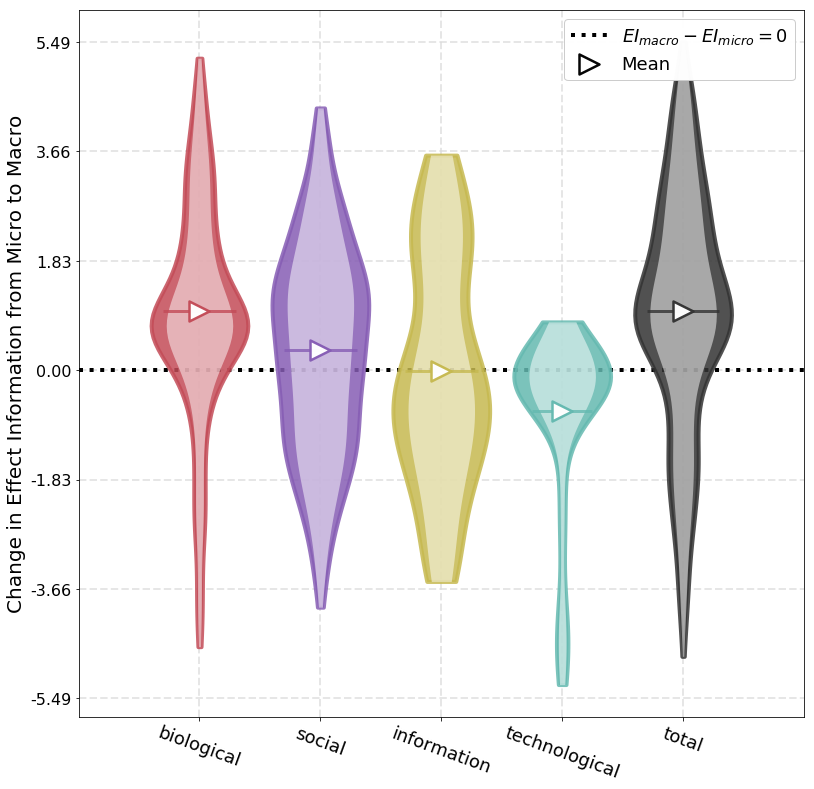

In [374]:
maxval = max(tot_plot)
# minval = min(tot_plot)
minval = -maxval
plt.rc('axes', axisbelow=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 13))

plt.hlines(0, 0, 6, linestyle=":", zorder=1, linewidth=4.0, label=r'$EI_{macro} - EI_{micro} = 0$')

############
i=0
parts = ax.violinplot(bio_plot, positions=[i+1], showmeans=False, 
                      showmedians=False, showextrema=False, widths=0.8)
pc = parts['bodies'][0]
pc.set_edgecolor(cols[i])
pc.set_facecolor(cols[i])
pc.set_alpha(0.85)
pc.set_linewidth(4.0)
parts = ax.violinplot(bio_plot, positions=[i+1], showmeans=False, 
                      showmedians=False, showextrema=False, widths=0.55)
pc = parts['bodies'][0]
pc.set_edgecolor(cols[i])
pc.set_facecolor('w')
pc.set_alpha(0.5)
pc.set_linewidth(0.0)
plt.hlines(np.mean(bio_plot), [i+0.7], [i+1.3], colors=cols[i], zorder=1, linewidth=3, alpha=0.8)
plt.scatter([i+1], [np.mean(bio_plot)], marker='>', s=400, facecolor='w', 
            edgecolors=cols[i], linewidth=2.5, alpha=0.98)
############
############
i=1
parts = ax.violinplot(soc_plot, positions=[i+1], showmeans=False, 
                      showmedians=False, showextrema=False, widths=0.8)
pc = parts['bodies'][0]
pc.set_edgecolor(cols[i])
pc.set_facecolor(cols[i])
pc.set_alpha(0.85)
pc.set_linewidth(4.0)
parts = ax.violinplot(soc_plot, positions=[i+1], showmeans=False, 
                      showmedians=False, showextrema=False, widths=0.55)
pc = parts['bodies'][0]
pc.set_edgecolor(cols[i])
pc.set_facecolor('w')
pc.set_alpha(0.5)
pc.set_linewidth(0.0)
plt.hlines(np.mean(soc_plot), [i+0.7], [i+1.3], colors=cols[i], zorder=1, linewidth=3, alpha=0.8)
plt.scatter([i+1], [np.mean(soc_plot)], marker='>', s=400, facecolor='w', 
            edgecolors=cols[i], linewidth=2.5, alpha=0.98)
############
############
i=2
parts = ax.violinplot(inf_plot, positions=[i+1], showmeans=False, 
                      showmedians=False, showextrema=False, widths=0.8)
pc = parts['bodies'][0]
pc.set_edgecolor(cols[i])
pc.set_facecolor(cols[i])
pc.set_alpha(0.85)
pc.set_linewidth(4.0)
parts = ax.violinplot(inf_plot, positions=[i+1], showmeans=False, 
                      showmedians=False, showextrema=False, widths=0.55)
pc = parts['bodies'][0]
pc.set_edgecolor(cols[i])
pc.set_facecolor('w')
pc.set_alpha(0.5)
pc.set_linewidth(0.0)
plt.hlines(np.mean(inf_plot), [i+0.7], [i+1.3], colors=cols[i], zorder=1, linewidth=3, alpha=0.8)
plt.scatter([i+1], [np.mean(inf_plot)], marker='>', s=400, facecolor='w', 
            edgecolors=cols[i], linewidth=2.5, alpha=0.98)
############
############
i=3
parts = ax.violinplot(tec_plot, positions=[i+1], showmeans=False, 
                      showmedians=False, showextrema=False, widths=0.8)
pc = parts['bodies'][0]
pc.set_edgecolor(cols[i])
pc.set_facecolor(cols[i])
pc.set_alpha(0.85)
pc.set_linewidth(4.0)
parts = ax.violinplot(tec_plot, positions=[i+1], showmeans=False, 
                      showmedians=False, showextrema=False, widths=0.55)
pc = parts['bodies'][0]
pc.set_edgecolor(cols[i])
pc.set_facecolor('w')
pc.set_alpha(0.5)
pc.set_linewidth(0.0)
plt.hlines(np.mean(tec_plot), [i+0.75], [i+1.25], colors=cols[i], zorder=1, linewidth=3, alpha=0.8)
plt.scatter([i+1], [np.mean(tec_plot)], marker='>', s=400, facecolor='w', 
            edgecolors=cols[i], linewidth=2.5, alpha=0.98)
###########
###########
i=4
parts = ax.violinplot(tot_plot, positions=[i+1], showmeans=False, 
                      showmedians=False, showextrema=False, widths=0.8)
pc = parts['bodies'][0]
pc.set_edgecolor(cols[i])
pc.set_facecolor(cols[i])
pc.set_alpha(0.85)
pc.set_linewidth(4.0)
parts = ax.violinplot(tot_plot, positions=[i+1], showmeans=False, 
                      showmedians=False, showextrema=False, widths=0.55)
pc = parts['bodies'][0]
pc.set_edgecolor(cols[i])
pc.set_facecolor('w')
pc.set_alpha(0.5)
pc.set_linewidth(0.0)
plt.hlines(np.mean(tot_plot), [i+0.7], [i+1.3], colors=cols[i], zorder=1, linewidth=3, alpha=0.8)
plt.scatter([i+1], [np.mean(tot_plot)], marker='>', s=400, facecolor='w', 
            edgecolors=cols[i], linewidth=2.5, alpha=0.98)
############

plt.scatter([i+10], [np.mean(tot_plot)], marker='>', s=400, facecolor='w', 
            edgecolors='k', linewidth=2.5, alpha=0.98, label="Mean")

xticks = ['biological','social','information','technological', 'total']
yticks = ["%.2f"%i for i in np.linspace(minval, maxval, len(xticks)+2)]
plt.xticks(np.linspace(1,len(xticks),len(xticks)), xticks, fontsize=18, rotation=340)
plt.yticks(np.linspace(minval, maxval, len(xticks)+2), yticks, fontsize=16)
plt.ylabel("Change in Effect Information from Micro to Macro", fontsize=20)
plt.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
plt.xlim(0,len(xticks)+1)
# plt.ylim(-100,100)
plt.legend(fontsize=18, framealpha=0.99)

# plt.savefig("../figs/pngs/Konect_CausalEmergence_Sampling01.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Konect_CausalEmergence_Sampling01.pdf", dpi=425, bbox_inches='tight')
plt.show()

_______________________